In [1]:
from pyspark.sql import Row, DataFrame, HiveContext
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer

sqlContext_H = HiveContext(sc)

from scipy.sparse import lil_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 250)

import numpy as np
import copy
from collections import OrderedDict
from dateutil.parser import parse


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline


HOST = 'hdfs://ip-10-0-0-159.ec2.internal:8020'

---

---

# Factorization

### Read data of the 7th month

In [2]:
fields_list = ( "ACCESS_DTTM", "USER_ID", "WORKSTATION" )
data = sqlContext_H.read.parquet( 
    HOST + "/parquet2/07/*"
).select(*fields_list).persist()

sqlContext_H.registerDataFrameAsTable(data, 'data')

data.limit(5).toPandas()

ACCESS_DTTM  USER_ID WORKSTATION
0 2016-07-05 00:00:05  2102006            
1 2016-07-05 00:00:07   207383     XYDT078
2 2016-07-05 00:00:07   207383     XYDT078
3 2016-07-05 00:00:07   113026            
4 2016-07-05 04:56:02   100012  EPCPRDCE01

### Calculate TF-IDF and encode USER_ID and WORKSTATION to label indices

In [4]:
%%time

# 1. Count all unique users of the defined month
total_users = sc.textFile(HOST + "/csv/unique_users_7.csv").count()


# 2. Calculate tf-idf
query = lambda table, total_users: """
    SELECT mainT1.USER_ID, mainT1.WORKSTATION, mainT1.TF * mainT2.IDF AS TF_IDF, mainT2.IDF
    FROM (SELECT T1.USER_ID, T1.WORKSTATION, T1.AMOUNT*1.0 / T2.TOTAL AS TF 
        FROM (SELECT USER_ID, WORKSTATION, COUNT(ACCESS_DTTM) AS AMOUNT
            FROM {table_name}
            GROUP BY USER_ID, WORKSTATION
        ) AS T1
        JOIN (SELECT USER_ID, COUNT(ACCESS_DTTM) AS TOTAL
            FROM {table_name}
            GROUP BY USER_ID
        ) AS T2
        ON T1.USER_ID = T2.USER_ID
    ) AS mainT1 JOIN (
        SELECT T.USER_ID, log10( 1 + {total_users} * 1.0 / COUNT(T.WORKSTATION) ) AS IDF
        FROM (SELECT USER_ID, WORKSTATION
            FROM {table_name}
            GROUP BY USER_ID, WORKSTATION
        ) AS T
        GROUP BY T.USER_ID
    ) AS mainT2 ON mainT1.USER_ID = mainT2.USER_ID
""".format(table_name=table, total_users=total_users)

res = sqlContext_H.sql(query("data", total_users)).persist()

# 3. Encode a string column of labels to a column of label indices
all_users = sqlContext_H.createDataFrame( 
        sc.textFile(HOST + "/csv/unique_users.csv").map(lambda p: Row(USER_ID=p)) 
    ).union( sqlContext_H.createDataFrame([Row(USER_ID='')]) ).persist()
all_workstations = sqlContext_H.createDataFrame( 
        sc.textFile(HOST + "/csv/unique_workstations.csv").map(lambda p: Row(WORKSTATION=p)) 
    ).union( sqlContext_H.createDataFrame([Row(WORKSTATION='')]) ).persist()

indexerU = StringIndexer(inputCol="USER_ID", outputCol="USER_ID_Index").fit(all_users)
indexerW = StringIndexer(inputCol="WORKSTATION", outputCol="WORKSTATION_Index").fit(all_workstations)

all_users.unpersist()
all_workstations.unpersist()

indexedU_df = indexerU.transform(res).withColumn(
        "USER_ID_Index", F.col("USER_ID_Index").cast(IntegerType())
    ).persist()

table = indexerW.transform(indexedU_df).withColumn(
        "WORKSTATION_Index", F.col("WORKSTATION_Index").cast(IntegerType())
    ).persist()

res.unpersist()
indexedU_df.unpersist()

CPU times: user 55.3 ms, sys: 14 ms, total: 69.2 ms
Wall time: 38.7 s


In [14]:
table.limit(5).toPandas()

USER_ID WORKSTATION    TF_IDF       IDF  USER_ID_Index  WORKSTATION_Index
0  100263              0.016842  3.088175           7279                296
1  100263    LABDT022  2.084139  3.088175           7279              10392
2  100263    LABDT051  0.013115  3.088175           7279              11737
3  100263    LABDT019  0.517273  3.088175           7279               3971
4  100263    LABDT064  0.076480  3.088175           7279               2181

In [5]:
%%time 

t = table.select("USER_ID_Index", "WORKSTATION_Index", "TF_IDF").toPandas()

total_users = sc.textFile(HOST + "/csv/unique_users.csv").count()
total_workstations = sc.textFile(HOST + "/csv/unique_workstations.csv").count()

def sparse_df_to_array(df, shape):
    """ Convert sparse dataframe to sparse array csr_matrix used by scikit learn. """
    arr = lil_matrix(shape, dtype=np.float32)
    for i in range(df.shape[0]):
        arr[df.ix[i, "USER_ID_Index"]-1, df.ix[i, "WORKSTATION_Index"]-1] = df.ix[i, "TF_IDF"]
    return arr.tocsr()

m = sparse_df_to_array(t, (total_users, total_workstations))

CPU times: user 4.2 s, sys: 54.7 ms, total: 4.26 s
Wall time: 24.7 s


### Caclulate cosine similarities

Prepare dataframes for each day from the 8th month

In [92]:
%%time

query = lambda table: """
    SELECT mainT1.USER_ID, mainT1.WORKSTATION, mainT1.TF * mainT2.IDF AS TF_IDF
    FROM (SELECT T1.USER_ID, T1.WORKSTATION, T1.AMOUNT*1.0 / T2.TOTAL AS TF 
        FROM (SELECT USER_ID, WORKSTATION, COUNT(ACCESS_DTTM) AS AMOUNT
            FROM {table_name}
            GROUP BY USER_ID, WORKSTATION
        ) AS T1
        JOIN (SELECT USER_ID, COUNT(ACCESS_DTTM) AS TOTAL
            FROM {table_name}
            GROUP BY USER_ID
        ) AS T2
        ON T1.USER_ID = T2.USER_ID
    ) AS mainT1 JOIN (
        SELECT T.USER_ID, 
               log10( 1 + (SELECT COUNT(DISTINCT(USER_ID)) AS count FROM {table_name}) * 1.0 / COUNT(T.WORKSTATION) ) AS IDF
        FROM (SELECT USER_ID, WORKSTATION
            FROM {table_name}
            GROUP BY USER_ID, WORKSTATION
        ) AS T
        GROUP BY T.USER_ID
    ) AS mainT2 ON mainT1.USER_ID = mainT2.USER_ID
""".format(table_name=table)

data_8_9 = data = sqlContext_H.read.parquet( 
    HOST + "/parquet2/08/*",
    HOST + "/parquet2/09/*"
).select(*fields_list).persist()


df_names = []
for w in range(31, 39):
    try: sqlContext_H.dropTempTable("df")
    except: pass
    df = data_8_9.filter("ACCESS_WEEK = {}".format(w)).persist()
    sqlContext_H.registerDataFrameAsTable(df, 'df')
    df_names.append('df_table_' + str(w))
    globals()['df_table_' + str(w)] = sqlContext_H.sql(query("df")).persist()
    df.unpersist()

CPU times: user 17.7 ms, sys: 8.63 ms, total: 26.4 ms
Wall time: 47.6 s


In [95]:
%%time

# 1. Fit FM 
svd = TruncatedSVD(n_components=50, n_iter=25, random_state=42)
svd.fit(m) 
print "svd.explained_variance_ratio_.sum() =", svd.explained_variance_ratio_.sum()
main1 = svd.transform(m)

# Here we will collect all cosine similarities for both users matrix of factors (cos1) and full FM (cos2)
cos = {}

for dn in df_names:
    d = dn.split("_")[-1]
    df_indexedU = indexerU.transform(globals()[dn]).withColumn(
                "USER_ID_Index", F.col("USER_ID_Index").cast(IntegerType())
            ).persist()
    df_table = indexerW.transform(df_indexedU).withColumn(
            "WORKSTATION_Index", F.col("WORKSTATION_Index").cast(IntegerType())
        ).select( "USER_ID_Index", "WORKSTATION_Index", "TF_IDF" ).toPandas()
    df_indexedU.unpersist()

    df_m = sparse_df_to_array(df_table, (total_users, total_workstations))

    print dn
    x1 = svd.transform(df_m)
    
    cos.update({d:[]})
    for i in range(df_m.shape[0]):
        cos[d].append(cosine_similarity(main1[i].reshape(1, -1), x1[i].reshape(1, -1))[0][0])

svd.explained_variance_ratio_.sum() = 0.372811426784
df_table_31
df_table_32
df_table_33
df_table_34
df_table_35
df_table_36
df_table_37
df_table_38
CPU times: user 29.7 s, sys: 58 ms, total: 29.8 s
Wall time: 4min


# Investigate the behaviour of users with different values of cosine similarities

In [96]:
def get_user_index_by_id(id):
    return indexerU.labels.index(str(id)) - 1

def get_user_id_by_index(idx):
    return indexerU.labels[idx + 1]

def get_workstation_index_by_id(id):
    return indexerW.labels.index(str(id)) - 1

def get_workstation_id_by_index(idx):
    return indexerW.labels[idx + 1]

In [97]:
user_indices = set()
for k,v in cos.iteritems():
    v = np.array(v)
    user_indices |= set(np.where((v > 0.2) & (v < 0.8))[0])
    
print len(user_indices)
print list(user_indices)[:25]

2585
[0, 8193, 8198, 8199, 9, 9560, 10926, 8216, 8217, 2735, 32, 34, 37, 38, 8233, 8235, 8240, 8246, 8201, 8248, 58, 60, 66, 8260, 8261]


In [100]:
%%time

colors = (
    'r', 'b', 'g', 'm', 'y', 'c', 'indigo', 'gold', 'pink', 'palegreen', 
    'grey', 'lime', 'darkred', 'salmon', 'navy', 'brown', 'coral'
) * 2

def draw3D(user_id, table, all_workstations, show=True):
    default = OrderedDict({i:0 for i in all_workstations})
    plot_data = OrderedDict({})
    
    u_table = table.filter("USER_ID = {}".format(user_id)).persist()
    workstations = set(map(lambda x: x[0], u_table.select("WORKSTATION").distinct().collect()))
    len(workstations)
    all_data = list(map(lambda x: (x[0],x[1]), u_table.select("WORKSTATION","TF_IDF").collect()))
    if show: print "07 months workstations usage:\n", all_data
    dict_i = copy.deepcopy(default)
    for workst_i, tfidf_i in all_data:
        dict_i[workst_i] = tfidf_i
    plot_data.update({0: dict_i})   
    u_table.unpersist()
    
    for dfn in df_names:
        d = int(dfn.split("_")[-1])
        workstations = workstations | set(map(lambda x: x[0], 
                globals()[dfn].filter("USER_ID = {}".format(user_id)).select("WORKSTATION").distinct().collect()
            ))
        d_data = list(map(lambda x: (x[0],x[1]), 
                globals()[dfn].filter("USER_ID = {}".format(user_id)).select("WORKSTATION","TF_IDF").collect()
            ))
        if show: print "workstations usage for week {}:".format(d), d_data
        dict_d = copy.deepcopy(default)
        for workst_i, tfidf_i in d_data:
            dict_d[workst_i] = tfidf_i
        plot_data.update({d: dict_d}) 
        
    fig = plt.figure(figsize=(16, 16))
    ax = fig.add_subplot(111, projection='3d')
    Y = range(len(workstations))
    ws = []
    c = 0
    for key, val in plot_data.iteritems():
        x = {}
        for k, v in val.iteritems():
            if k in workstations:
                x[k] = v
        if ws == []:
            ws = x.keys()
        ax.bar(Y, np.array(x.values()), zs=c, zdir='y', color=colors[c], alpha=0.7)
        c += 1
    ax.set_xlabel('Workstation')
    plt.xticks(Y, Y)
    ax.set_ylabel('Week')
    plt.yticks(range(len(range(31, 39)) + 1), [0] + list(range(31, 39)))
    ax.set_zlabel('TF-IDF')
    plt.show()
    
    print "WORKSTATIONS:"
    for i,j in enumerate(ws):
        print "{} - {}".format(i,j)
        
    fig = plt.figure(figsize=(16,4))
    axes = plt.gca()
    cos_sims_factors = [cos[str(i)][idx] for i in range(31, 39)]
    cos_sims_tfidf = [
        cosine_similarity(np.array(plot_data[0].values()).reshape(1, -1), np.array(vals.values()).reshape(1, -1))[0][0] 
        for k,vals in plot_data.iteritems() if k!=0
    ]
    X = np.arange(len(cos_sims_tfidf))
    plt.bar(X + 0.05, cos_sims_factors, width=0.9, alpha=0.7, color='r', label="Factors")
    plt.bar(X + 0.15, cos_sims_tfidf, width=0.7, alpha=0.7, color='g', label="TF-IDF")
    plt.xlabel("Weeks", fontsize=12)
    plt.ylabel('Cosine similarity', fontsize=12)
    plt.xticks(range(len(range(31, 39))), list(range(31, 39)))
    plt.title("Cosine similarities", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
all_workstations = sc.textFile(HOST + "/csv/unique_workstations.csv").collect()
all_workstations.append("")

CPU times: user 58.1 ms, sys: 12.1 ms, total: 70.2 ms
Wall time: 184 ms


# Compare calculated similarities with workstation usage diagram

user_id = 203289


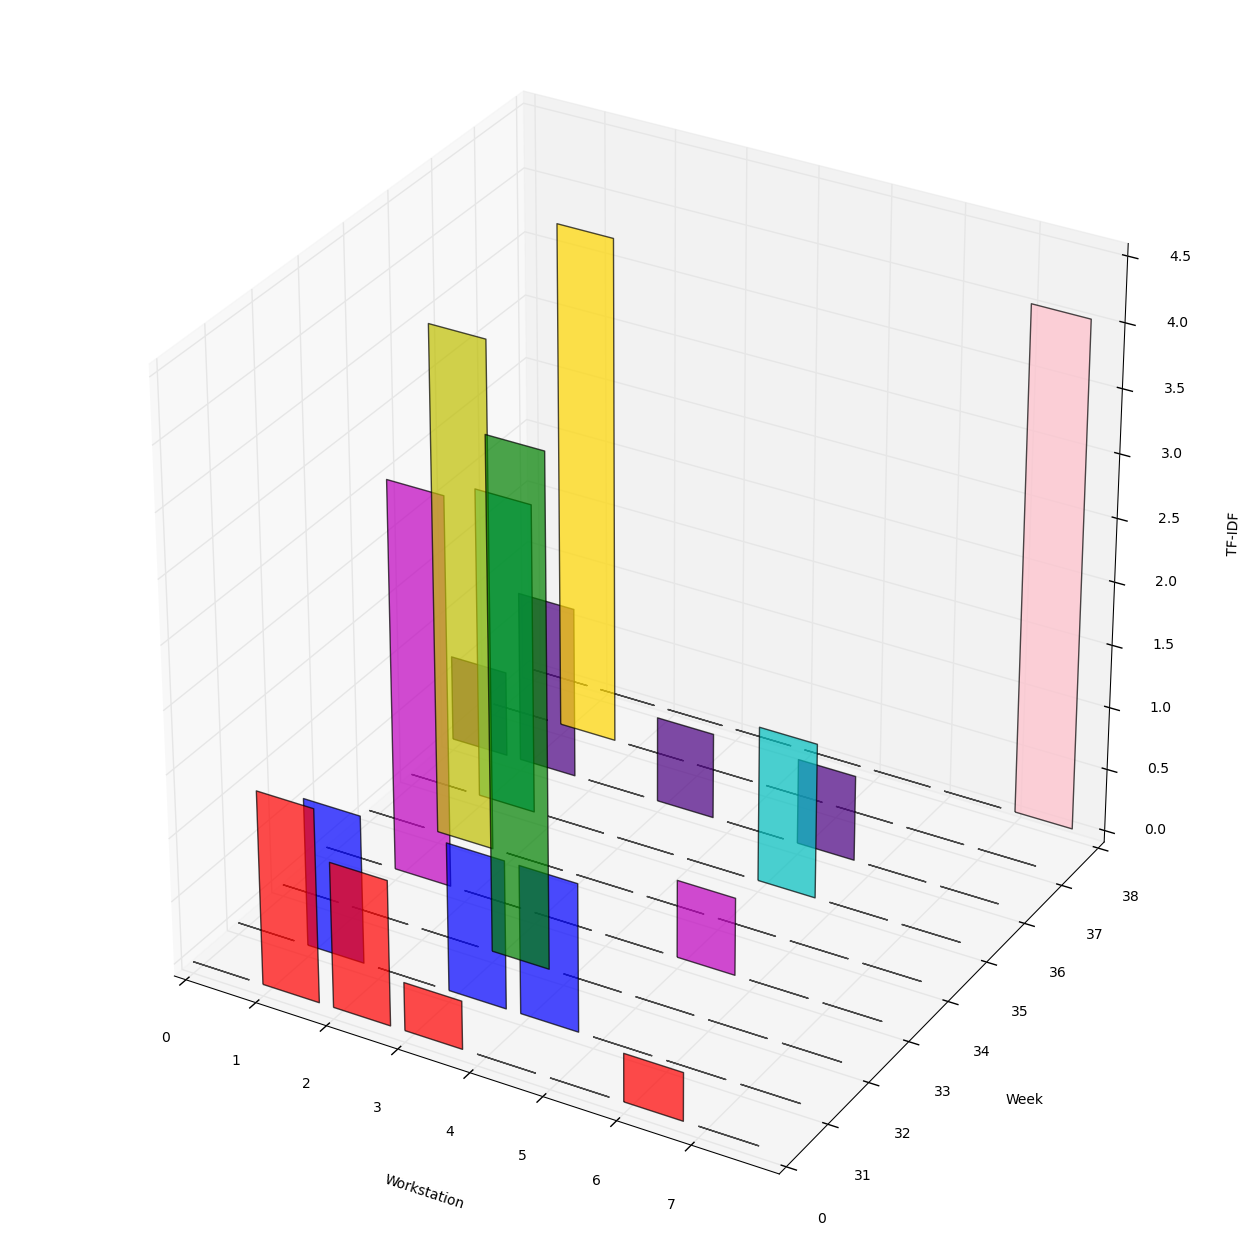

WORKSTATIONS:
0 - GENERIC
1 - ORDT058
2 - ORDT040
3 - ORDT041
4 - ORDT017
5 - ORTC007
6 - ORTCOR09
7 - ORTCOR08


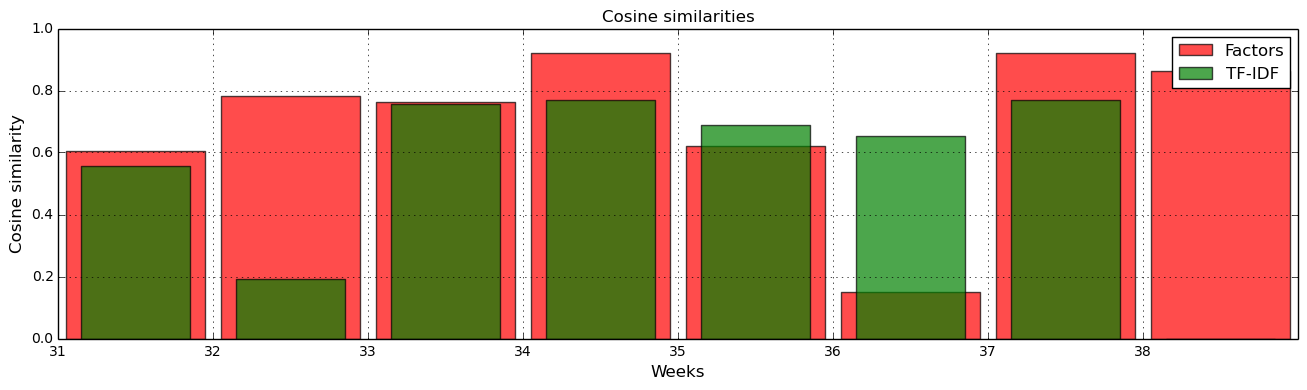

CPU times: user 2.07 s, sys: 21 ms, total: 2.09 s
Wall time: 5.3 s


In [101]:
%%time

idx = 8233
user_id = get_user_id_by_index(idx)
print "user_id =", user_id
    
draw3D(user_id, table, all_workstations, show=False)

> * When a new workstation appeared (day 6 and day 16), cosine similarity was enoung far from unity (0.58649 and 0.72558 respectively)
> * When a workstation (2 - ORDT041) was used more intensivelly then previously, cosine similarity lies also far from unity (0.78280 for days 4 and 8)
> * If a user uses the same workstation as before with similar frequency, cosine similary is approxiamtely equal to 1
> * If a user did not use any workstation, cosine similarity is identically equal to 0

user_id = 17864


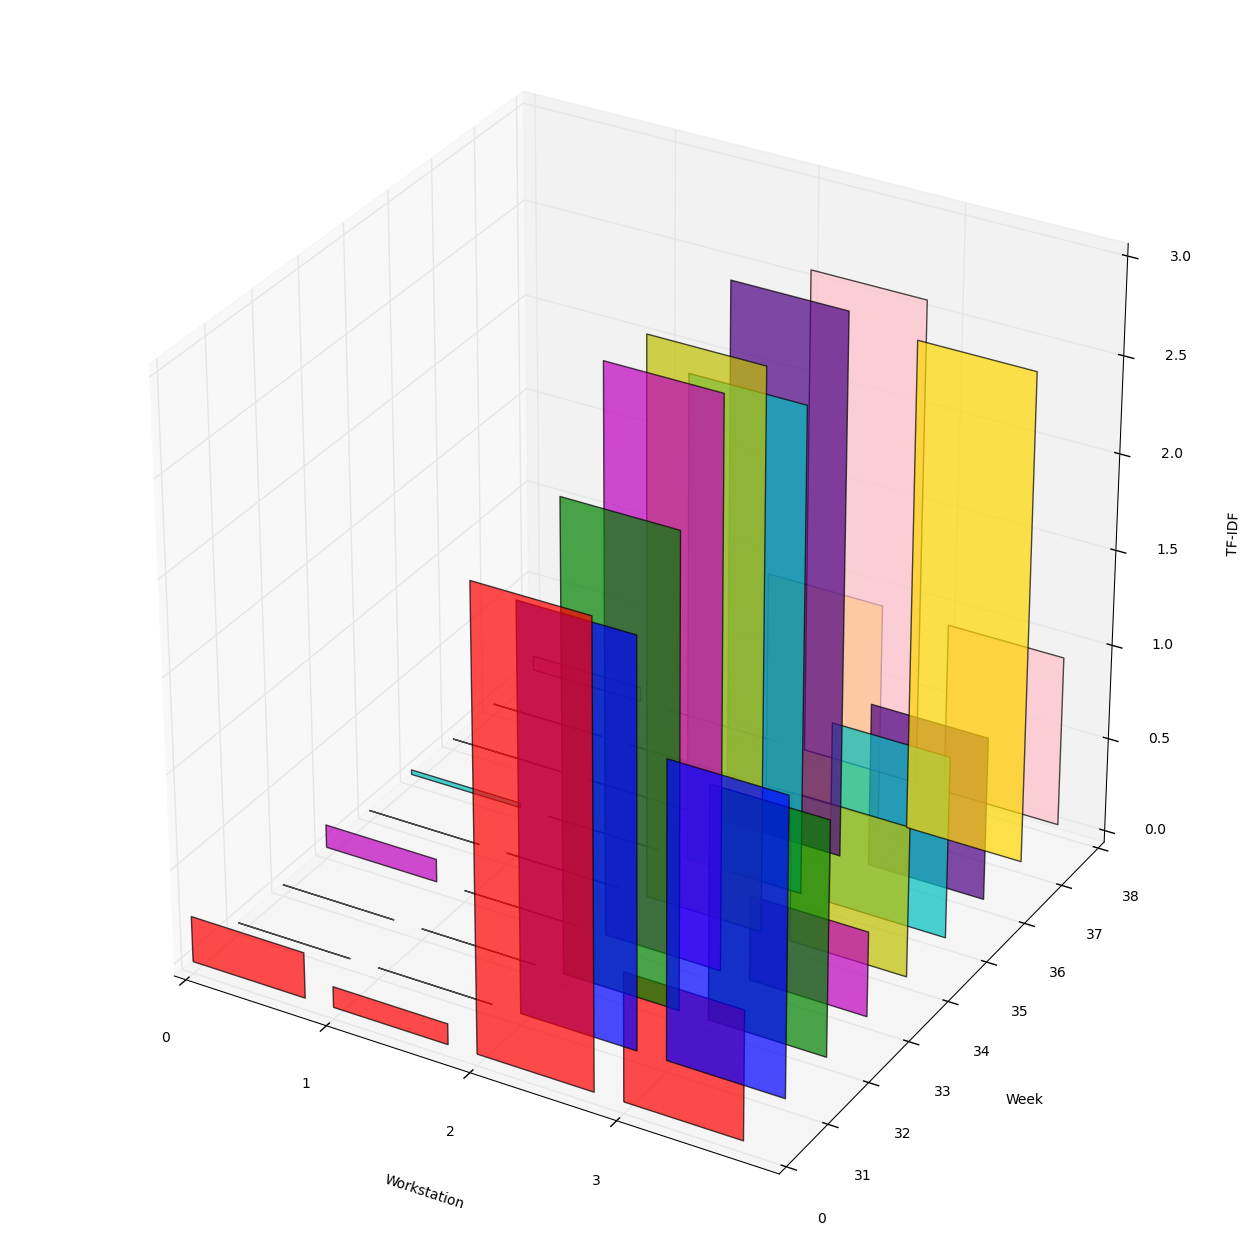

WORKSTATIONS:
0 - HY4865
1 - GENERIC
2 - HY4866
3 - HY4153


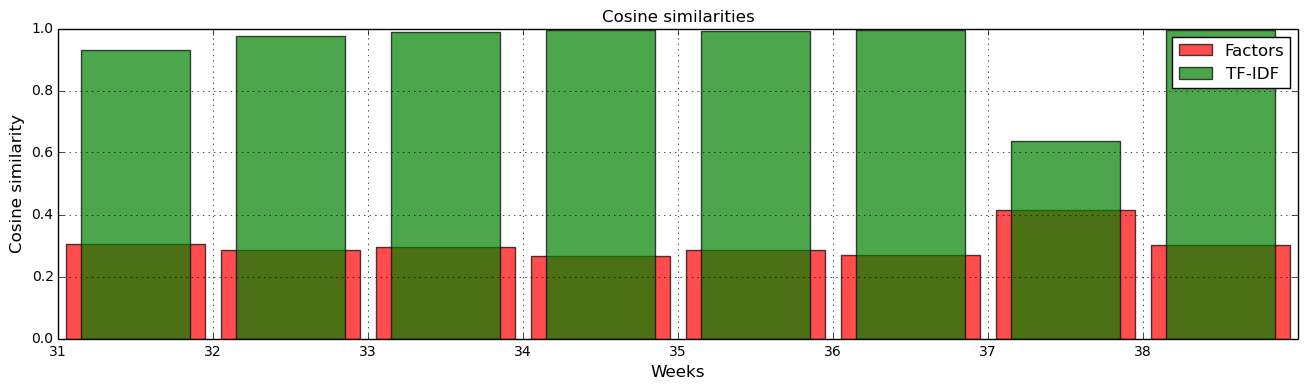

CPU times: user 2.05 s, sys: 5.3 ms, total: 2.05 s
Wall time: 5.29 s


In [104]:
%%time

idx = 12334
user_id = get_user_id_by_index(idx)
print "user_id =", user_id
    
draw3D(user_id, table, all_workstations, show=False)

user_id = 113675


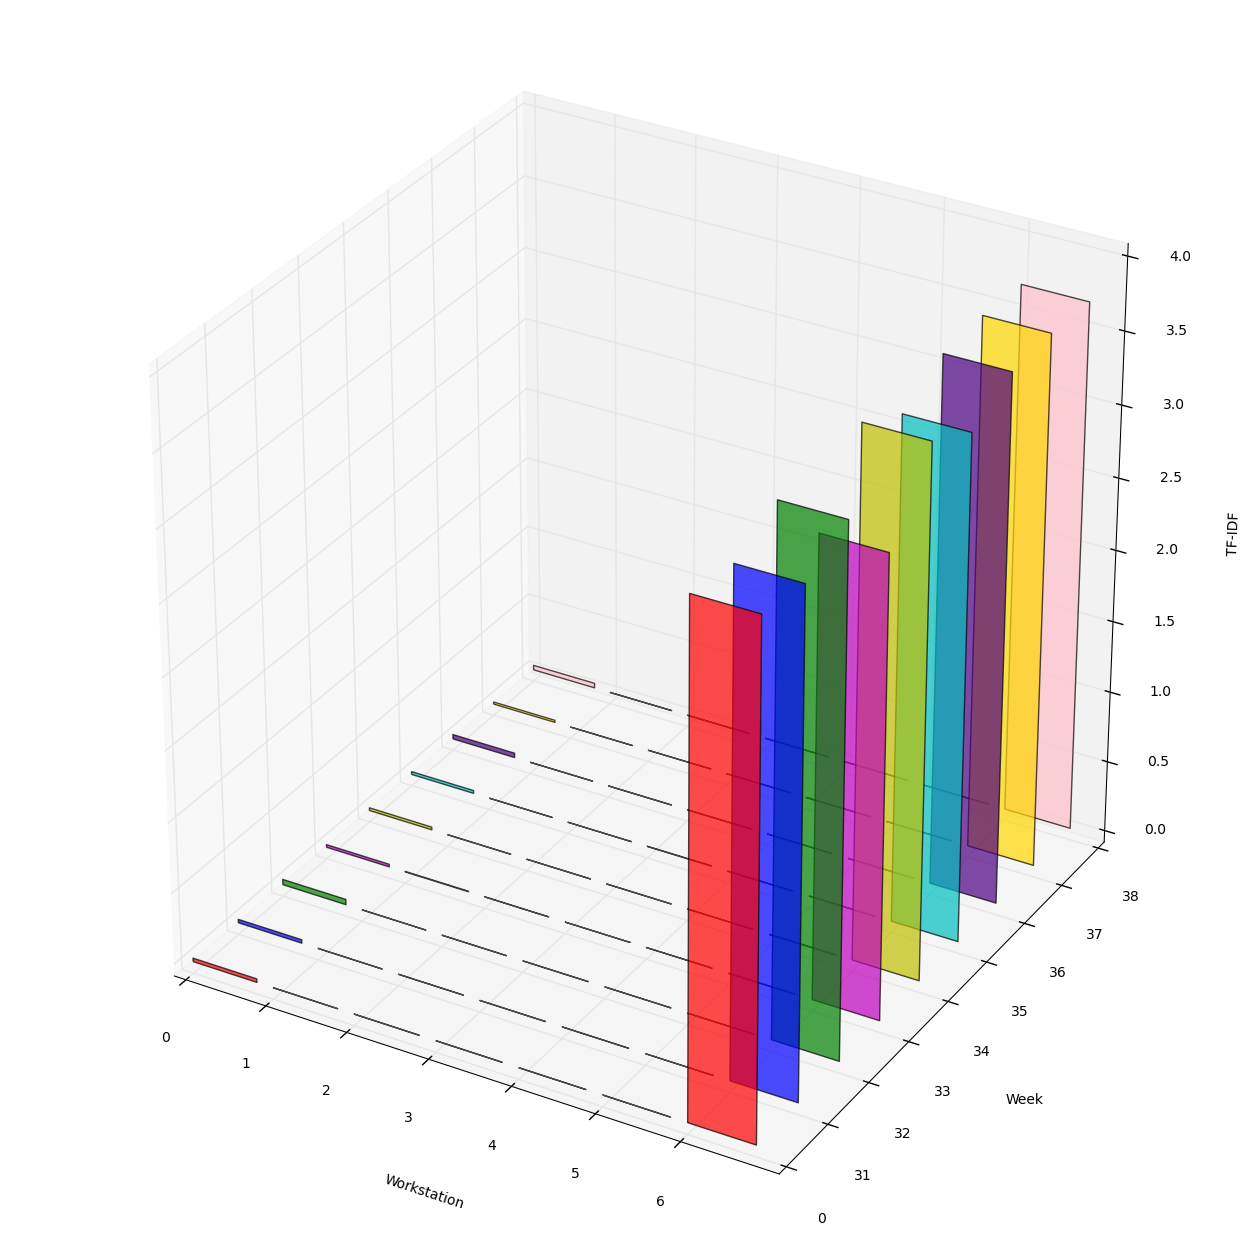

WORKSTATIONS:
0 - 
1 - EMG20LT006
2 - GENERIC
3 - EMG20LT010
4 - EMG20DTPL016
5 - EMG20DTPL004
6 - EMG20DTPL010


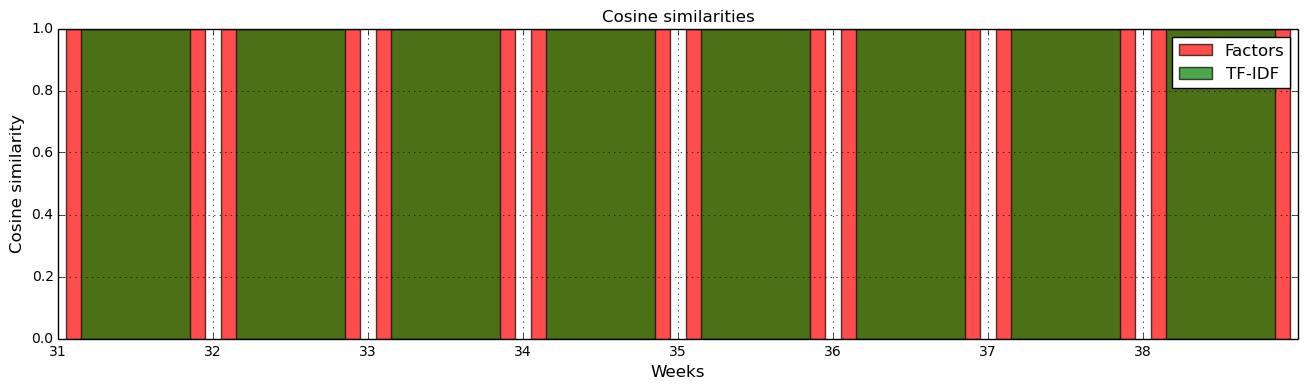

CPU times: user 2.15 s, sys: 7.96 ms, total: 2.16 s
Wall time: 6.52 s


In [105]:
%%time

idx = 4105
user_id = get_user_id_by_index(idx)
print "user_id =", user_id
    
draw3D(user_id, table, all_workstations, show=False)

user_id = 17177


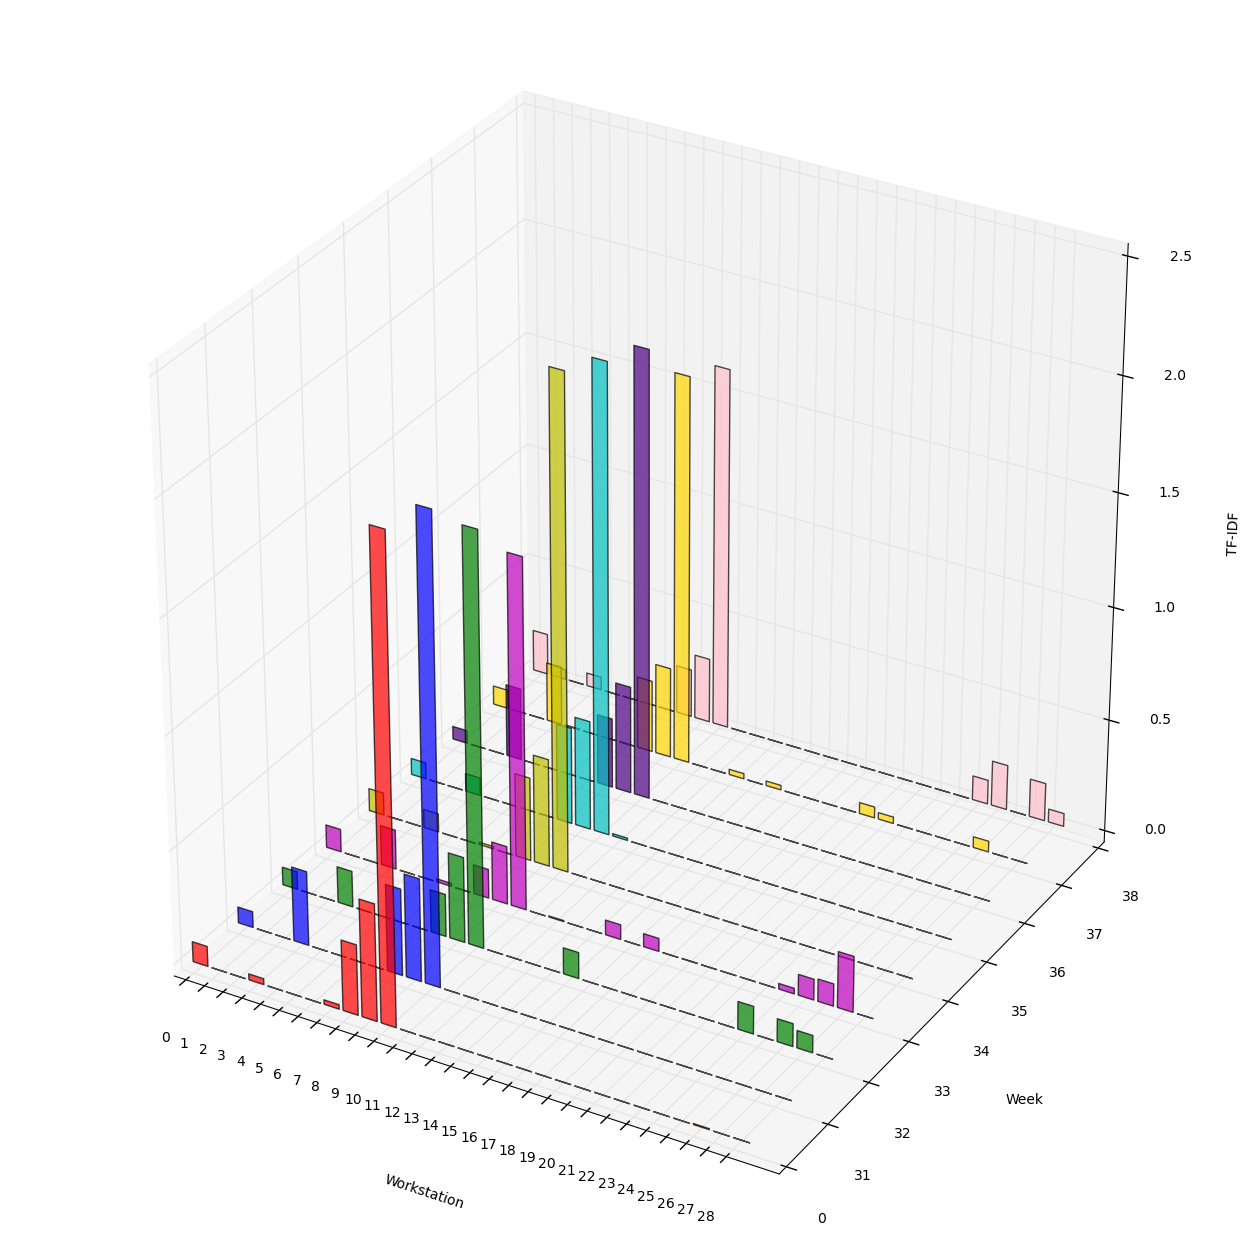

WORKSTATIONS:
0 - 
1 - 3NEADT003
2 - 6NEANS09
3 - GENERIC
4 - WS0762
5 - HY3100
6 - HY7543
7 - HY7542
8 - HY7541
9 - HY7540
10 - HY7546
11 - HY7544
12 - 4NWANS13
13 - CVCUDT042
14 - HY4764
15 - CVCUDT049
16 - HY0494
17 - WA4TC005
18 - 6NEADT009
19 - 6NEADT006
20 - WA4TC049
21 - 4NWANS09
22 - HY2541
23 - OSWDT001
24 - MEDDT033
25 - MEDDT032
26 - MEDDT036
27 - MEDDT035
28 - MEDDT034


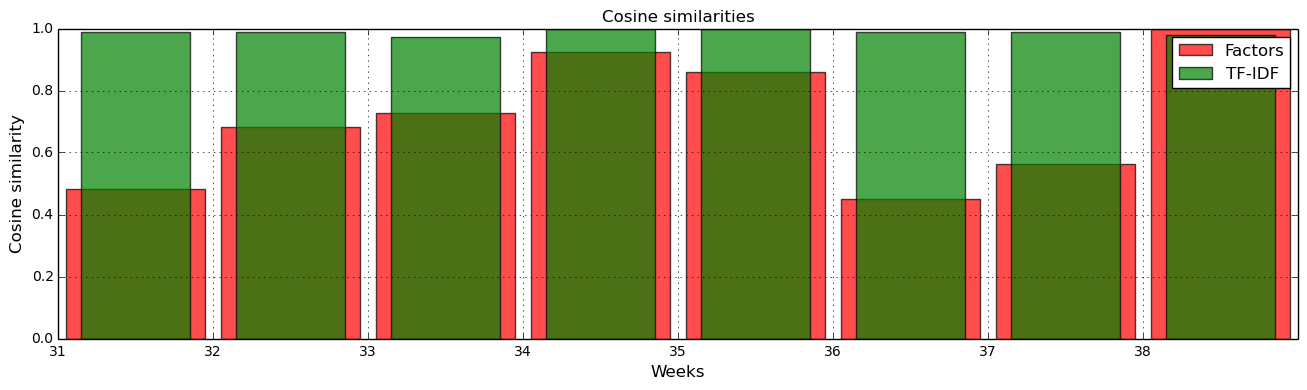

CPU times: user 2.65 s, sys: 12.7 ms, total: 2.67 s
Wall time: 5.92 s


In [106]:
%%time

idx = 8199
user_id = get_user_id_by_index(idx)
print "user_id =", user_id
    
draw3D(user_id, table, all_workstations, show=False)

user_id = 17072


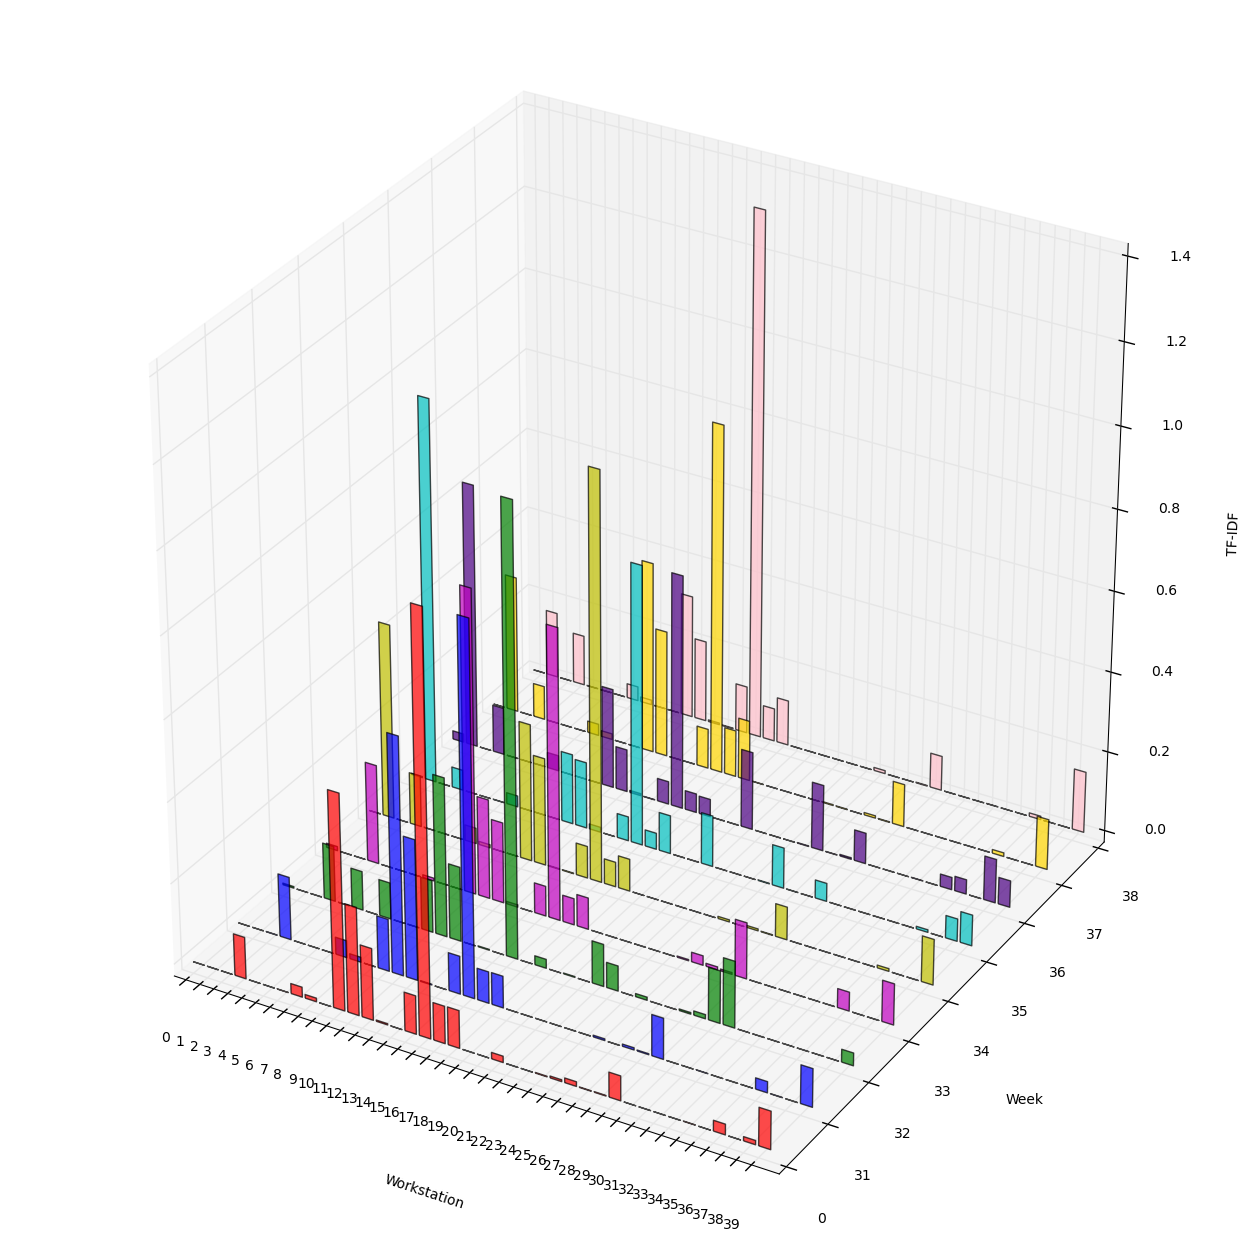

WORKSTATIONS:
0 - 
1 - PC0032
2 - ORDT060
3 - V90030
4 - PC0227
5 - HYP472
6 - S10185
7 - S10182
8 - S10181
9 - RIS159
10 - HY6714
11 - S10171
12 - S10172
13 - GENERIC
14 - RIS609
15 - S10176
16 - S10177
17 - S10174
18 - S10175
19 - RIS603
20 - HY1060
21 - V90065
22 - HY1617
23 - HY1616
24 - HY7307
25 - HY7306
26 - HY3255
27 - PC0024
28 - PC0023
29 - V90062
30 - HY6749
31 - HY2053
32 - ORDT001
33 - HY6271
34 - ORDT002
35 - V90051
36 - V90006
37 - PACUDTNP003
38 - V90042
39 - S10173


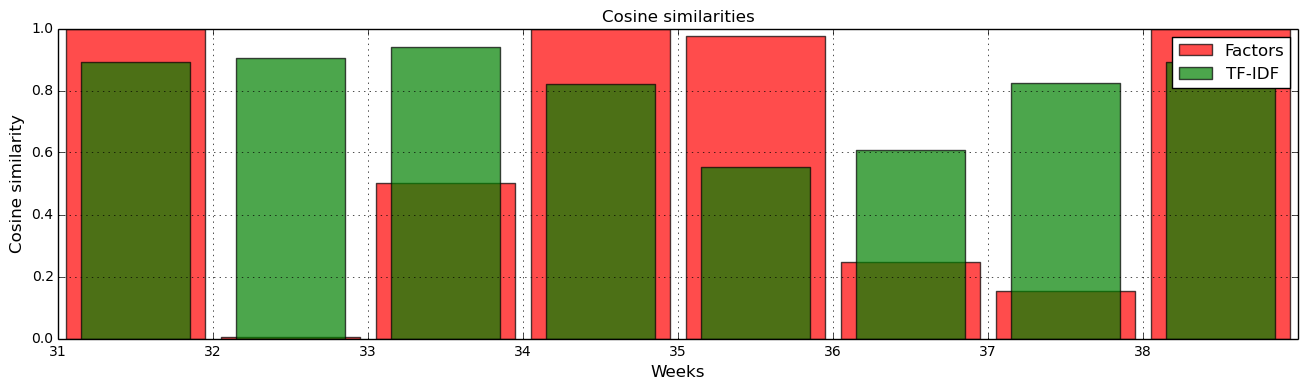

CPU times: user 2.93 s, sys: 17.6 ms, total: 2.95 s
Wall time: 6.4 s


In [107]:
%%time

idx = 8193
user_id = get_user_id_by_index(idx)
print "user_id =", user_id
    
draw3D(user_id, table, all_workstations, show=False)

user_id = 12209


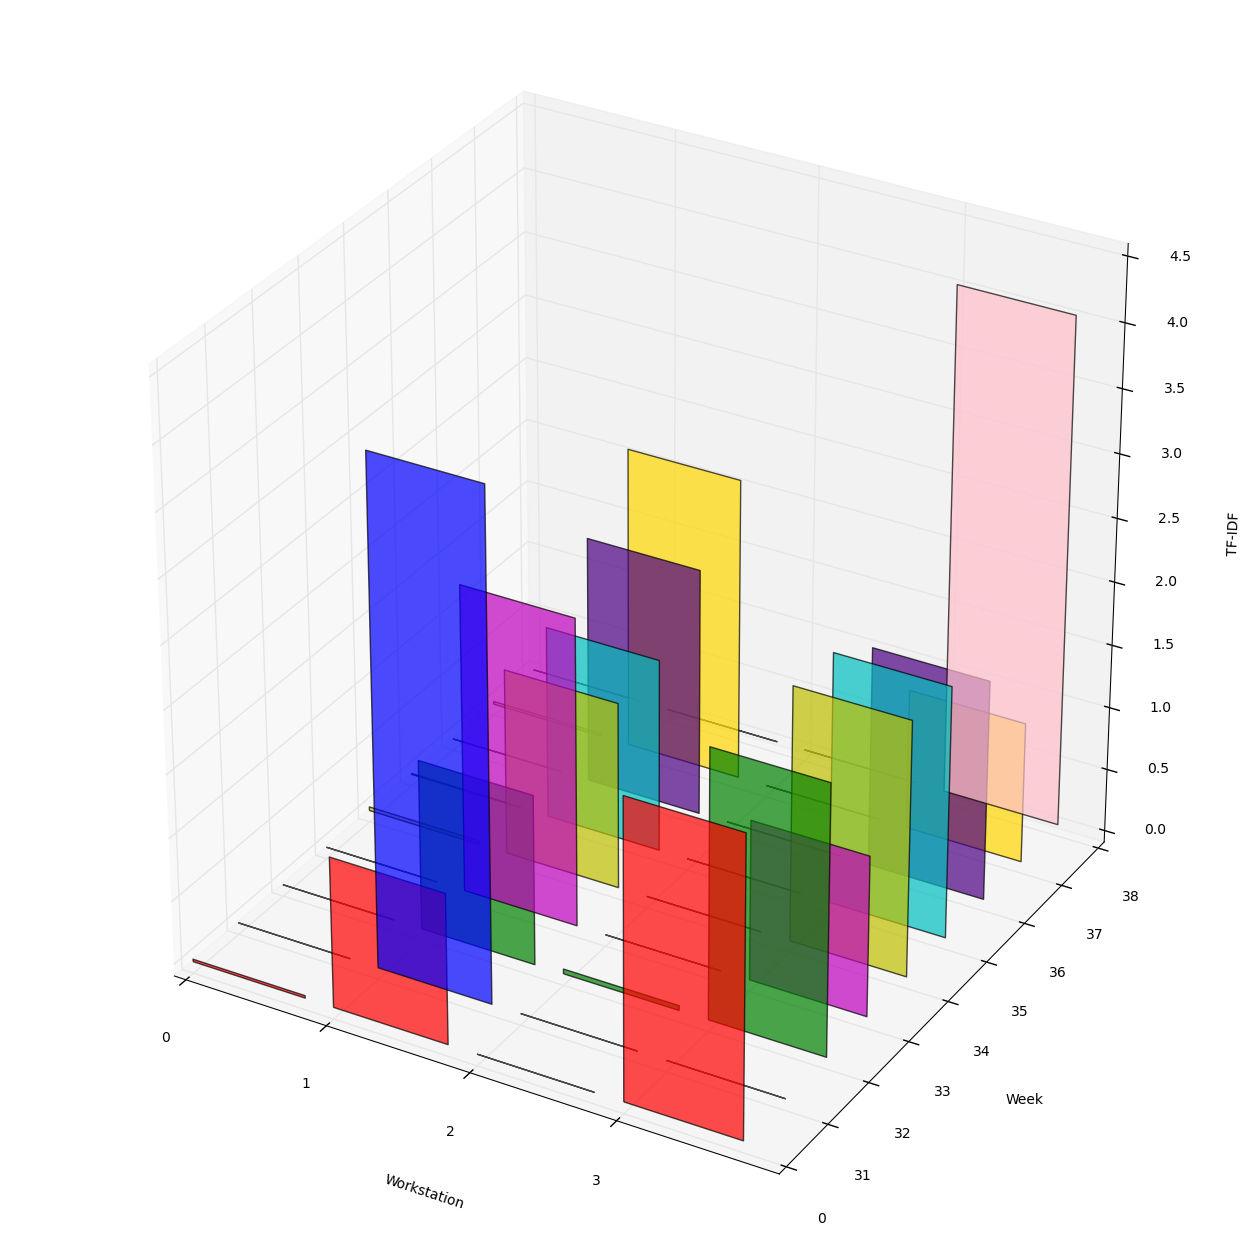

WORKSTATIONS:
0 - 
1 - HY5318
2 - HY8268
3 - HY5315


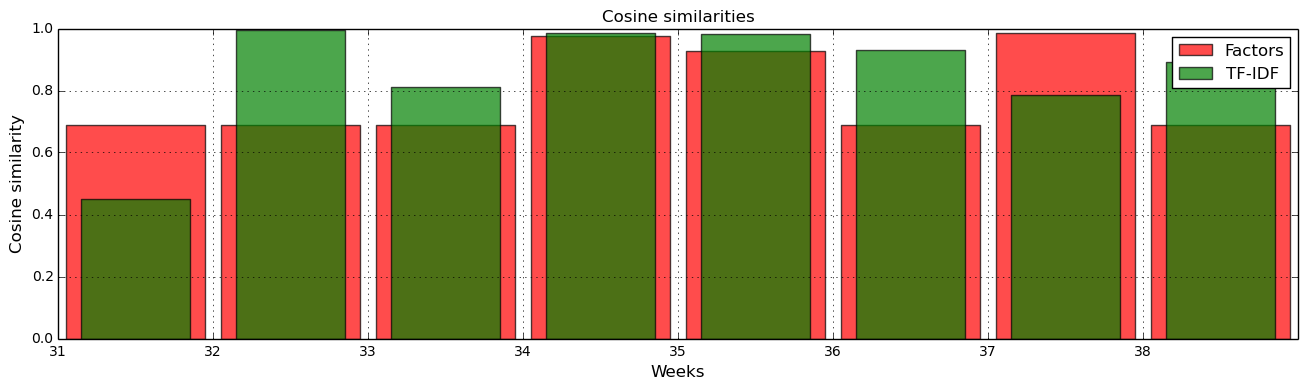

CPU times: user 2.05 s, sys: 16.7 ms, total: 2.07 s
Wall time: 5.48 s


In [109]:
%%time

idx = 9
user_id = get_user_id_by_index(idx)
print "user_id =", user_id
    
draw3D(user_id, table, all_workstations, show=False)

user_id = 203589


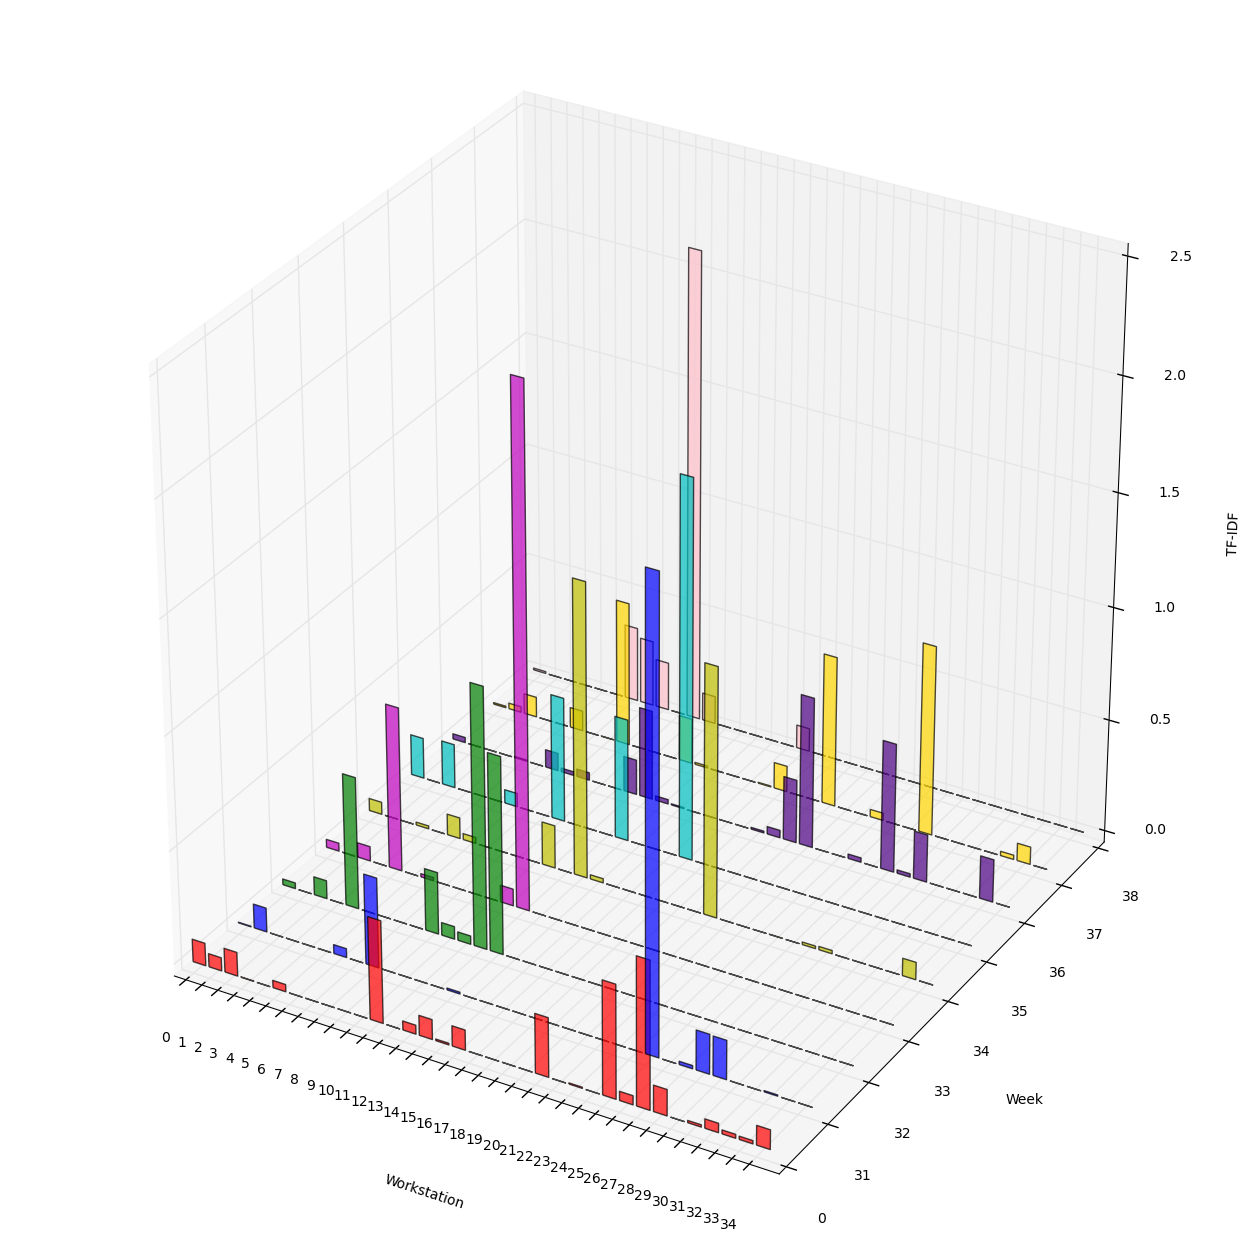

WORKSTATIONS:
0 - 
1 - 1SEARM186
2 - 1SEARM190
3 - 1SEARM191
4 - 1SEARM192
5 - 1SEARM193
6 - 1SEARM194
7 - 1SEARM195
8 - 1SEARM196
9 - 1SEARM197
10 - PEDDT016
11 - 1SEANS05
12 - 1SEANS04
13 - 1SEANS03
14 - 1SEARM185
15 - 1SEANS01
16 - XYDT041
17 - 1SEANS02
18 - 0SWANS07
19 - ICUFLO014
20 - SSUFLO003
21 - 1SEANS13
22 - 0SWANS08
23 - PEDDT002
24 - 1SEARM189
25 - 1SEANS14
26 - 1SEANS15
27 - 1SEANS16
28 - 1SEARM184
29 - 1SEARM183
30 - 1SEARM182
31 - 1SEANS12
32 - BCADT056
33 - 1SEARM187
34 - 1SEARM172


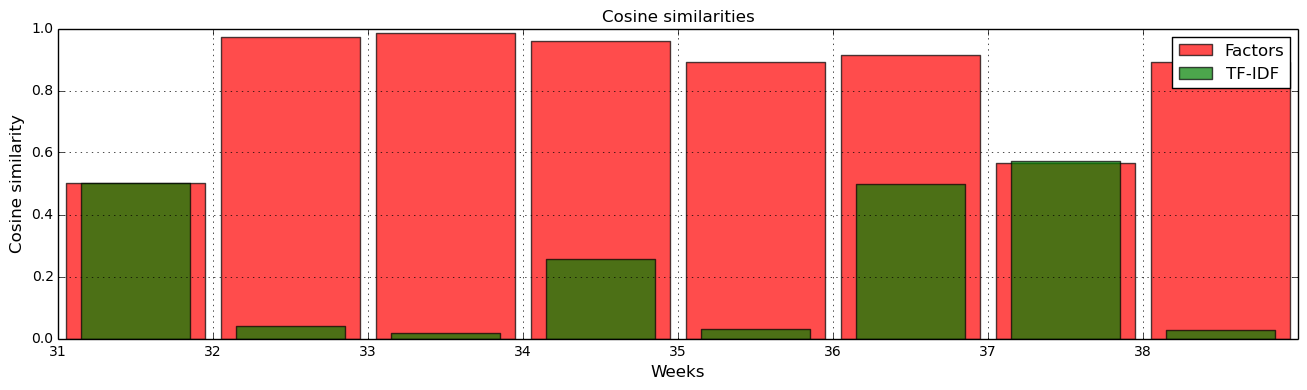

CPU times: user 2.76 s, sys: 9.37 ms, total: 2.77 s
Wall time: 6.2 s


In [110]:
%%time

idx = 32
user_id = get_user_id_by_index(idx)
print "user_id =", user_id
    
draw3D(user_id, table, all_workstations, show=False)

user_id = 202320


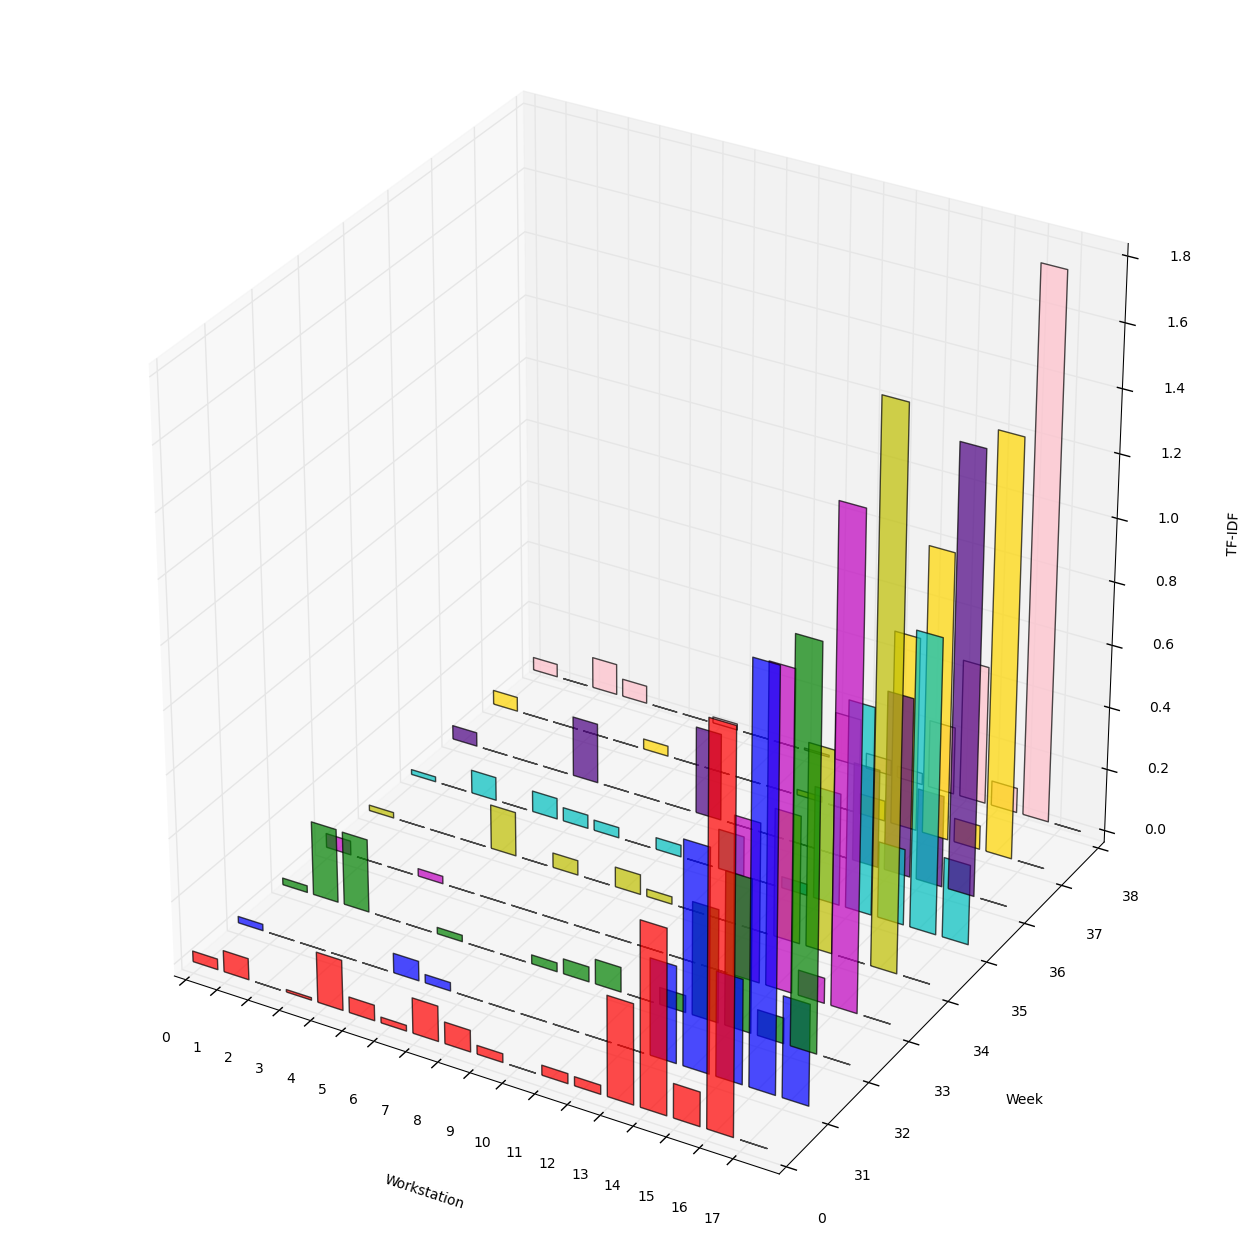

WORKSTATIONS:
0 - 
1 - EMG17DT012
2 - EMG17RM1
3 - EMG17RM6
4 - EMG17RM7
5 - EMG17RM4
6 - EMG17RM5
7 - EMG17DT008
8 - EMG17RM8
9 - EMG17RM9
10 - EMG17RM2
11 - EMG17RM3
12 - EMG17RM10
13 - EMG17RM11
14 - EMG17RM12
15 - EMG17RM13
16 - EMG17DT027
17 - EMG17DT034


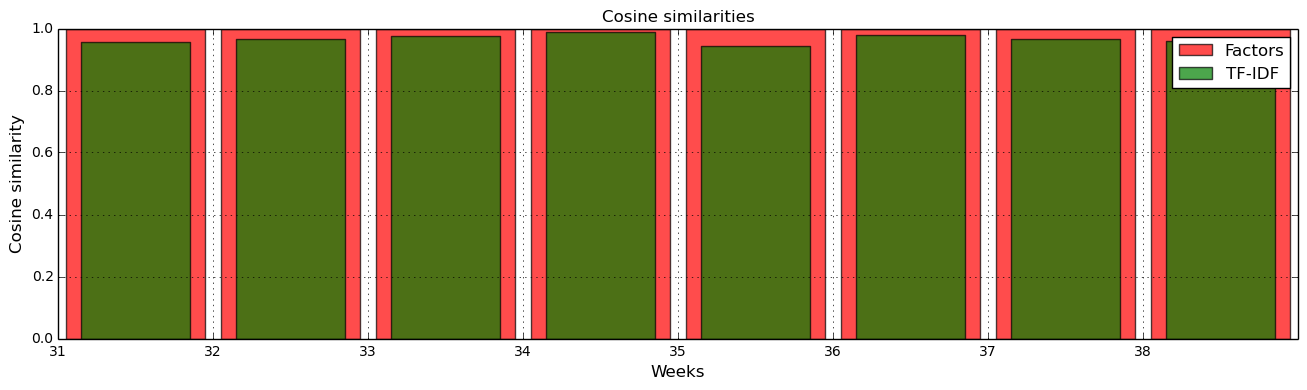

CPU times: user 2.36 s, sys: 32.5 ms, total: 2.4 s
Wall time: 5.77 s


In [111]:
%%time

idx = 33
user_id = get_user_id_by_index(idx)
print "user_id =", user_id
    
draw3D(user_id, table, all_workstations, show=False)

user_id = 206709


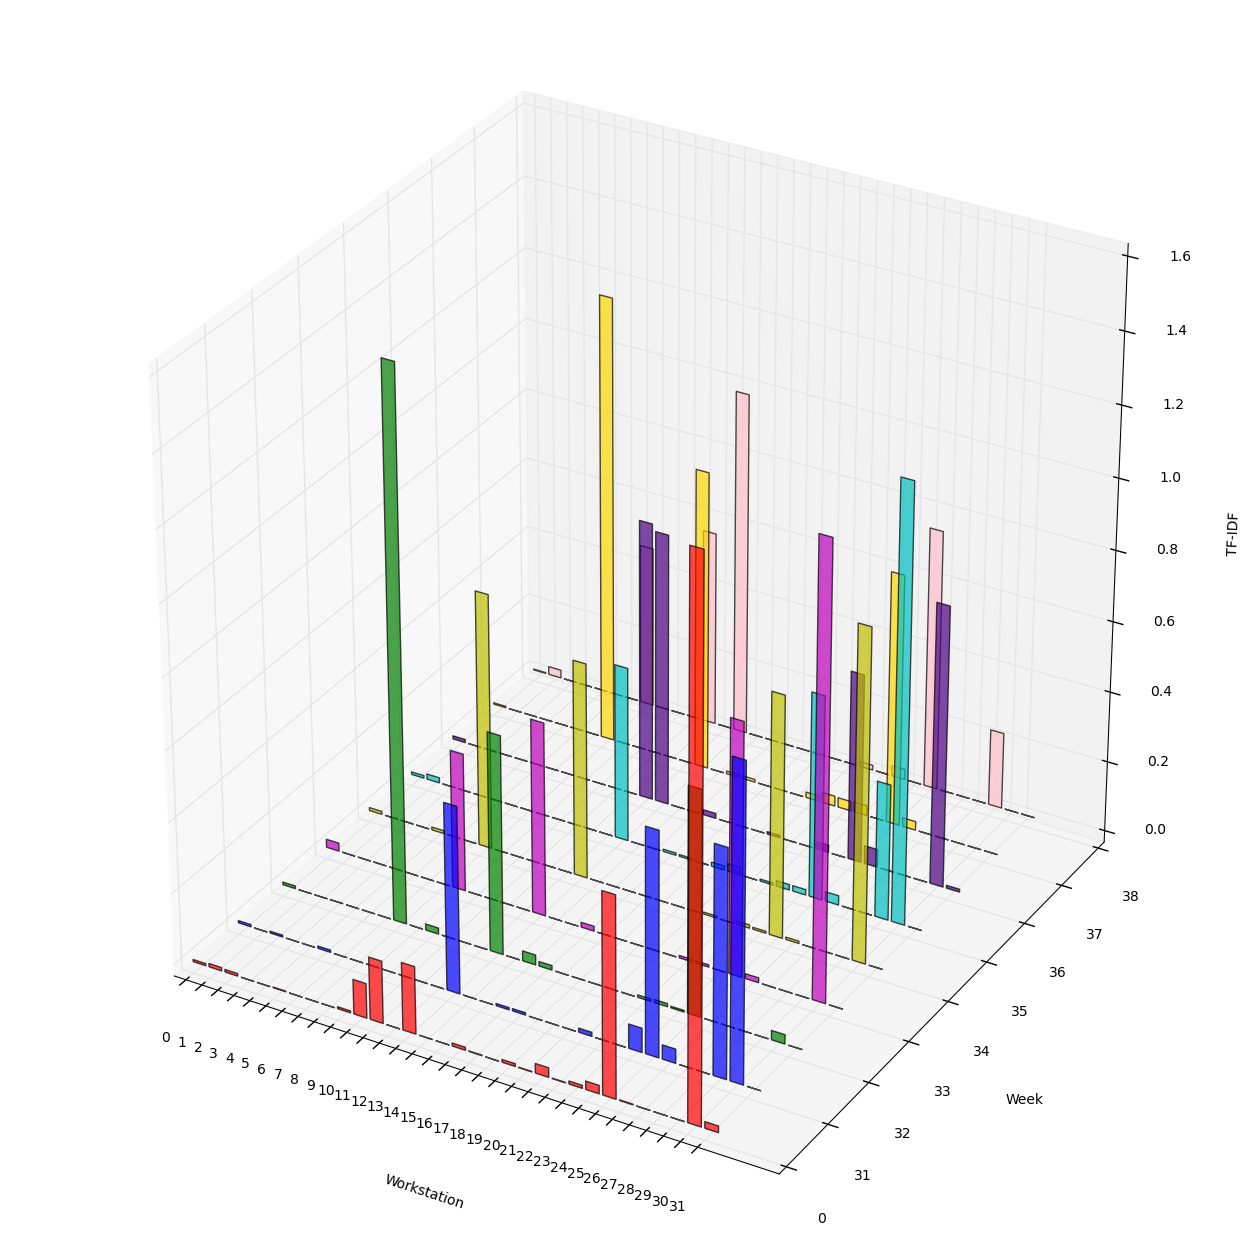

WORKSTATIONS:
0 - 
1 - EMGNRM1
2 - EMGNRM2
3 - ENIWARRLT003
4 - EMGNRM7
5 - EMGNRM6
6 - GENERIC
7 - EMGNDT032
8 - ENIWARRDT013
9 - EMGNDT030
10 - ENIWARRDT015
11 - ENIWARRDT014
12 - ENIWARRDT017
13 - ENIWARRDT016
14 - EMGNDT016
15 - EMGNRM4
16 - ENIWARRDT006
17 - ENIWARRDT005
18 - ENIWARRDT012
19 - EMGNDT029
20 - ENIWARRDT008
21 - EMGNDT024
22 - ENIWARRDT007
23 - ENIWARRDT004
24 - EMGNDT027
25 - EMGNDT020
26 - ENIWARRDT003
27 - EMGNDT036
28 - ENIWARRDT021
29 - ENIWARRDT022
30 - EMGNDT040
31 - EMGNDT023


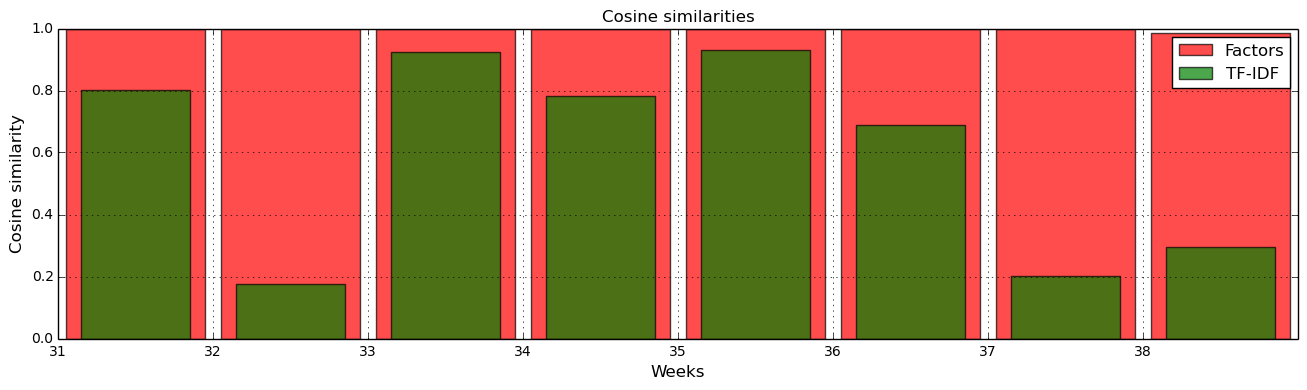

CPU times: user 2.75 s, sys: 24.4 ms, total: 2.77 s
Wall time: 6.12 s


In [116]:
%%time

idx = 1001
user_id = get_user_id_by_index(idx)
print "user_id =", user_id
    
draw3D(user_id, table, all_workstations, show=False)

user_id = 204309


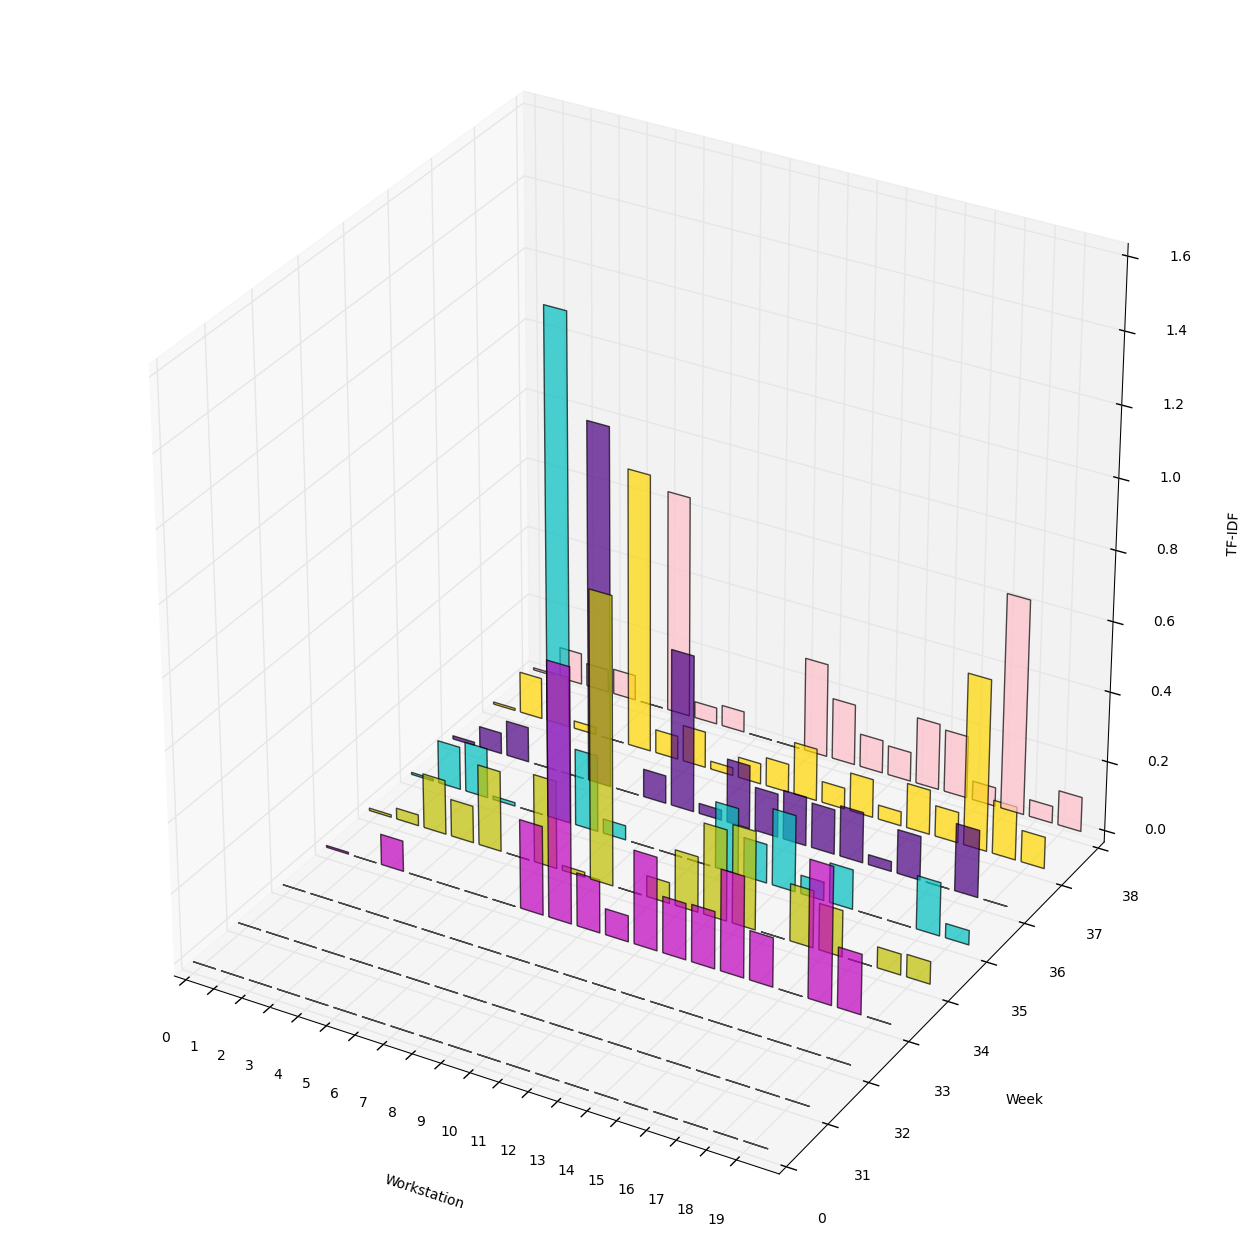

WORKSTATIONS:
0 - 
1 - BBRKRM12
2 - GENERIC
3 - BBRKRM11
4 - BBRKDT051
5 - BBRKDT044
6 - BBRKRM01
7 - BBRKLT006
8 - BBRKDT053
9 - BBRKLT005
10 - BBRKRM06
11 - BBRKRM07
12 - BBRKRM04
13 - BBRKRM02
14 - BBRKRM03
15 - BBRKRM10
16 - BBRKTC01
17 - BBRKDT052
18 - BBRKRM08
19 - BBRKRM09


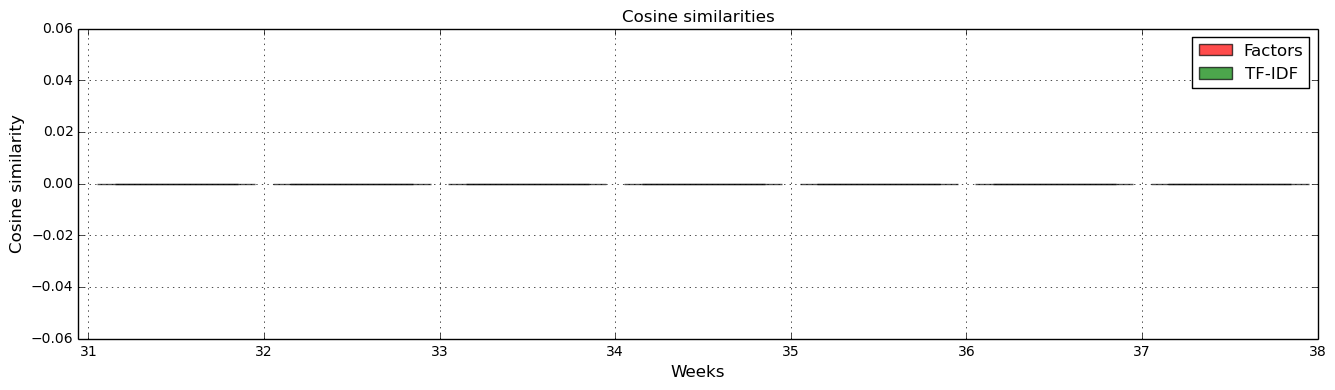

CPU times: user 2.47 s, sys: 9.18 ms, total: 2.48 s
Wall time: 5.88 s


In [114]:
%%time

idx = 100
user_id = get_user_id_by_index(idx)
print "user_id =", user_id
    
draw3D(user_id, table, all_workstations, show=False)

# k nearest neighbors

**He we are going to find out groups of users with similar behaviour (in other words with close TF-IDFs)**

In [ ]:
%%time

from sklearn.neighbors import NearestNeighbors

renew = False
if renew:
    svd = TruncatedSVD(n_components=50, n_iter=25, random_state=42)
    svd.fit(m) 
    print "svd.explained_variance_ratio_.sum() =", svd.explained_variance_ratio_.sum()
    main1 = svd.transform(m)
    main2 = svd.inverse_transform(main1)

nbrs = NearestNeighbors(n_neighbors=25, algorithm='ball_tree', n_jobs=-1).fit(main2)
# Array `indices` contains numbers of users with similar behaviour
# Array `distances` contains euclidean distances between each pair of users from `indices`
distances, indices = nbrs.kneighbors(main2)

In [120]:
indices

array([[    0,  7232, 11812, ...,  6335,  8182, 12064],
       [    1,  8985,  8063, ...,  9647,  8600,  1180],
       [ 5985,  3135,   179, ...,  1991,  3110,  6013],
       ..., 
       [ 5985,  3135,   179, ...,  1991,  3110,  6013],
       [ 5985,  3135,   179, ...,  1991,  3110,  6013],
       [12865,   268, 10951, ...,  7416,  2861,  3421]])

In [121]:
distances

array([[  0.00000000e+00,   3.85035157e-09,   1.03442521e-08, ...,
          2.96112182e-08,   2.97179598e-08,   2.97319307e-08],
       [  0.00000000e+00,   9.98358171e-06,   2.79774117e-05, ...,
          4.43104902e-04,   4.47064435e-04,   4.82419054e-04],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   1.30703367e-03,   1.57590829e-03, ...,
          3.77129056e-03,   3.93797399e-03,   4.00488141e-03]])

In [15]:
%%time

graph = nbrs.kneighbors_graph(main2).toarray()
print graph

[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]]
CPU times: user 22min 58s, sys: 308 ms, total: 22min 58s
Wall time: 6min 18s


### Read users data

In [19]:
secure_rdd = sc.textFile(HOST + "/users_info/SecureHealEmpTest.csv").persist()
first = secure_rdd.first()
header = first.split("|")
row_data = secure_rdd.filter(lambda x: x != first).map( lambda x: x.split("|") ) \
                    .map( lambda p: Row(**{header[i]:p[i] for i in range(len(header))}) ).persist()
secure_rdd.unpersist() 
users = sqlContext.createDataFrame(row_data).select(
    "Employee", "JobName", "DeptName", "ProcDesc", "EmpStatus" 
).persist()
row_data.unpersist();
sqlContext_H.registerDataFrameAsTable(users, 'users')

users.limit(5).toPandas()

Employee                    JobName         DeptName         ProcDesc  \
0   100059  Dir, IP Med Svs & Nsg Svs     MED SURGICAL  Edward Hospital   
1   100067             Telemetry Tech  CARDIAC MONITOR  Edward Hospital   
2   100133          Patient Svs Coord  PT SERVICES/CRT  Edward Hospital   
3   100151                         RN   PEDS SPEC PROC  Edward Hospital   
4   100199             Dir, Radiology   SURGICAL ADMIN  Edward Hospital   

  EmpStatus  
0        A1  
1        A5  
2        A2  
3        A2  
4        A1

## Find out relationships between users within each group of 10 elements in `indices`

In [118]:
%%time

fields_list = ( "ACCESS_DTTM", "USER_ID", "WORKSTATION" )
full_data = sqlContext_H.read.parquet(HOST + "/parquet2/*/*").select(*fields_list).persist()
sqlContext_H.registerDataFrameAsTable(full_data, 'full_data')

query = """
    SELECT T.USER_ID, users.JobName, users.DeptName, users.ProcDesc AS HospName, users.EmpStatus,
           T.RECORDS_AMOUNT, T.WORKSTATION_AMOUNT, T.WORKSTATIONs
    FROM (SELECT USER_ID, COUNT(ACCESS_DTTM) AS RECORDS_AMOUNT, 
           COUNT(DISTINCT(WORKSTATION)) AS WORKSTATION_AMOUNT, concat_ws('; ', collect_set(WORKSTATION)) AS WORKSTATIONs
        FROM full_data
        GROUP BY USER_ID
    ) AS T
    JOIN users
    ON T.USER_ID = users.Employee
"""
users_grouped = sqlContext_H.sql(query).persist()

CPU times: user 5.13 ms, sys: 31 µs, total: 5.16 ms
Wall time: 615 ms


In [119]:
users_grouped.limit(3).toPandas()

USER_ID             JobName        DeptName         HospName EmpStatus  \
0  100263        Med Tech III          PF LAB  Edward Hospital        A2   
1  101021  Dir, IP Cardiology  Cardiac Tele 8  Edward Hospital        A1   
2  102536                  RN   CRITICAL CARE  Edward Hospital        A1   

   RECORDS_AMOUNT  WORKSTATION_AMOUNT  \
0           97944                  17   
1             819                   2   
2           11670                  18   

                                                                                                                                                                               WORKSTATIONs  
0                          LABDT021; LABDT064; LABDT019; LABDT017; LABDT028; LABDT010; LABDT027; LABDT031; LABDT009; LABFLO001; LABDT051; LABDT011; LABDT022; LABDT002; GENERIC; LABDT024;   
1                                                                                                                                                                       8NEANS16; CVCUDT031  
2  NEUROTC01; XYDT095; WA4RM474; CATHDT012; 6NEARM6610; 1NEARM1608; ; WA4RM470; CATHDT009; 1NEARM1605; 1NEARM1607; CATHWOW04; XYDT055; 2NEARM2607; 6NEANS13; BCADT011; 6NEADT005; NEUROTC02

## Divide nearest neighbours into groups taking into account the amount of users with known job name and department 

In [111]:
all_known_users = set(map(lambda x: x[0], users.select("Employee").collect()))

labels = indexerU.labels
indices_users = [set([labels[idx + 1] for idx in lst]) for lst in indices]

groups = {i: [] for i in range(0,26)}
for num, lst in enumerate(indices_users):
    x = len(all_known_users & lst)
    flag = True
    for _, el in groups[x]:
        if set(lst) == set(el):
            flag = False
            break
    if flag:
        groups[x].append((num, lst))

for k, v in groups.iteritems():
    print "Groups of {} known users: {}".format(k, len(v))

Groups of 0 known users: 73
Groups of 1 known users: 83
Groups of 2 known users: 150
Groups of 3 known users: 240
Groups of 4 known users: 339
Groups of 5 known users: 499
Groups of 6 known users: 611
Groups of 7 known users: 675
Groups of 8 known users: 699
Groups of 9 known users: 723
Groups of 10 known users: 595
Groups of 11 known users: 477
Groups of 12 known users: 401
Groups of 13 known users: 383
Groups of 14 known users: 291
Groups of 15 known users: 243
Groups of 16 known users: 203
Groups of 17 known users: 214
Groups of 18 known users: 217
Groups of 19 known users: 179
Groups of 20 known users: 120
Groups of 21 known users: 96
Groups of 22 known users: 69
Groups of 23 known users: 41
Groups of 24 known users: 13
Groups of 25 known users: 5


In [122]:
print "Distances:"
print distances[groups[25][0][0]]

x0 = users_grouped.filter("USER_ID IN ({})".format(", ".join(["\'{}\'".format(i) for i in groups[25][0][1]]))).selectExpr(
    "USER_ID", "JobName", "DeptName", "HospName", "EmpStatus", "RECORDS_AMOUNT as Requests", "WORKSTATION_AMOUNT as WS_amount"
).toPandas()
x0.head(25)

Distances:
[ 0.          0.17691175  0.53518626  0.53518626  3.39559548  3.47812317
  3.4864479   3.48892292  3.49704972  3.49777579  3.5008726   3.50204687
  3.50250009  3.50419863  3.50443268  3.5045696   3.50478328  3.50490399
  3.50492674  3.50492677  3.50496841  3.50503959  3.50504444  3.50522611
  3.50529447]


USER_ID                        JobName                DeptName  \
0   202439                             RN                 SURGERY   
1   204396                             RN                 SURGERY   
2   106122                             RN                 SURGERY   
3   201674                             RN                 SURGERY   
4   204410                             RN                 SURGERY   
5   202168                             RN                 SURGERY   
6   101600                             RN                 SURGERY   
7   111332                             RN                 SURGERY   
8   201880                             RN                 SURGERY   
9   103447                             RN                 SURGERY   
10  112020                             RN                 SURGERY   
11  107372                 Unit Secretary                 SURGERY   
12  108449                             RN                 SURGERY   
13  115579                             RN                 SURGERY   
14  201301                 Unit Secretary                 SURGERY   
15  201660                 Unit Secretary                 SURGERY   
16  203097                 Unit Secretary                 SURGERY   
17  114780                             RN                 SURGERY   
18  107812                             RN                 SURGERY   
19  202089  Lead Anesth Surg Support Tech              ANESTHESIA   
20  100118                             RN                 SURGERY   
21  115792                             RN                 SURGERY   
22  104199              Ultrasound Tech I  WOMEN'S IMAGING CENTER   
23  202158                             RN                 SURGERY   
24  114734                             RN                 SURGERY   

           HospName EmpStatus  Requests  WS_amount  
0   Edward Hospital        A1     13831         27  
1   Edward Hospital        A1     23232         38  
2   Edward Hospital        A2     19672         40  
3   Edward Hospital        A1      9317         26  
4   Edward Hospital        A1     20854         28  
5   Edward Hospital        A1     18864         31  
6   Edward Hospital        A1     15114         27  
7   Edward Hospital        A1     21819         29  
8   Edward Hospital        A1     21180         27  
9   Edward Hospital        A1     16047         41  
10  Edward Hospital        A1     12169         41  
11  Edward Hospital        A2     17536          7  
12  Edward Hospital        A1      7761         23  
13  Edward Hospital        A1     12163         27  
14  Edward Hospital        A2      2331          3  
15  Edward Hospital        A2     16778          1  
16  Edward Hospital        A2     17922          3  
17  Edward Hospital        L1      7985         21  
18  Edward Hospital        A1     11530         26  
19  Edward Hospital        A1      5899         20  
20  Edward Hospital        A1      9939         22  
21  Edward Hospital        A1     83227         22  
22  Edward Hospital        A1     47791         18  
23  Edward Hospital        A2     13345         35  
24  Edward Hospital        A1     21204         40

In [123]:
print "Distances:"
print distances[groups[15][1][0]]

x1 = users_grouped.filter("USER_ID IN ({})".format(", ".join(["\'{}\'".format(i) for i in groups[15][0][1]]))).selectExpr(
    "USER_ID", "JobName", "DeptName", "HospName", "EmpStatus", "RECORDS_AMOUNT as Requests", "WORKSTATION_AMOUNT as WS_amount"
).toPandas()
x1.head(25)

Distances:
[ 0.          0.00825883  0.13226565  0.13715963  0.27734502  0.28437249
  0.3074846   0.31814413  0.4043434   0.41588123  0.42811635  0.42862435
  0.43741843  0.48307269  0.51250248  0.5342738   1.04520797  1.10877353
  1.16166189  1.30866055  1.33979946  1.7953905   2.08643863  2.21154652
  2.72647742]


USER_ID                        JobName         DeptName         HospName  \
0   205247                             RN  CARDIAC CATH LB  Edward Hospital   
1   204698                             RN  CARDIAC CATH LB  Edward Hospital   
2   108468            Clin Nurse Educator  CARDIAC CATH LB  Edward Hospital   
3   201704                     Rad Tech I        RADIOLOGY  Edward Hospital   
4   202661                             RN  RAD SPEC PRO HH  Edward Hospital   
5   102599       Advance Specialty Leader  CARDIAC CATH LB  Edward Hospital   
6   111561  Spec Proc Tech, Intrventl Sts  CARDIAC CATH LB  Edward Hospital   
7   203638                             RN  CARDIAC CATH LB  Edward Hospital   
8   201082       Advance Specialty Leader  CARDIAC CATH LB  Edward Hospital   
9   204314  Spec Proc Tech, Intrventl Sts  CARDIAC CATH LB  Edward Hospital   
10  204638                             RN  CARDIAC CATH LB  Edward Hospital   
11  201492                             RN  CARDIAC CATH LB  Edward Hospital   
12  205226  Spec Proc Tech, Intrventl Sts  CARDIAC CATH LB  Edward Hospital   
13  201088           Clin Leader, Nursing  CARDIAC CATH LB  Edward Hospital   
14  204801                             RN        ENDOSCOPY  Edward Hospital   

   EmpStatus  Requests  WS_amount  
0         A1     12770         13  
1         A1     11083         11  
2         A2       844         12  
3         A1      1011          9  
4         A1     10751         31  
5         A1      8545         15  
6         A1      1145         10  
7         A1      9675         16  
8         A1      3245         21  
9         A1      4596         12  
10        A1      3517         12  
11        A1      8976         24  
12        A1      3975         14  
13        A1      2281          9  
14        A1      6502          8

In [124]:
print "Distances:"
print distances[groups[10][0][0]]

x2 = users_grouped.filter("USER_ID IN ({})".format(", ".join(["\'{}\'".format(i) for i in groups[10][0][1]]))).selectExpr(
    "USER_ID", "JobName", "DeptName", "HospName", "EmpStatus", "RECORDS_AMOUNT as Requests", "WORKSTATION_AMOUNT as WS_amount"
).toPandas()
x2.head(25)

Distances:
[  0.00000000e+00   1.44435405e-11   1.52642950e-11   1.70013435e-11
   1.93161415e-11   1.98097685e-11   2.05243112e-11   2.06948415e-11
   2.12974976e-11   2.15892243e-11   2.20291357e-11   2.20432068e-11
   2.23607805e-11   2.28230537e-11   2.30021491e-11   2.33539846e-11
   2.40440459e-11   2.41426738e-11   2.41635264e-11   2.42762205e-11
   2.43802882e-11   2.44029039e-11   2.48288184e-11   2.50195980e-11
   2.52911047e-11]


USER_ID                     JobName                      DeptName  \
0  104635      Application Analyst II  ISS ENTP CAPITALIZED SALARIE   
1  301633        Patient Access Assoc       PATIENT ACCESS SERVICES   
2  115077           Social Worker MSW              CANCER CENTER SU   
3  115031     Service Desk Technician          ISS SERVICE DELIVERY   
4  102274        Mgd Care Denial Spec                 PATIENT ACCTS   
5  114715          Physical Therapist                 OP REHAB SVCS   
6  314373   Bill & Collect Specialist                EMA BUS OFFICE   
7  114670      Application Analyst IV  ISS ENTP CAPITALIZED SALARIE   
8  106862  Dir, EMG Office Operations                Administration   
9  115699         Quality Review Spec                CTR CLIN EXCEL   

                     HospName EmpStatus  Requests  WS_amount  
0             Edward Hospital        A2       266          2  
1  Elmhurst Memorial Hospital        A1      1970          7  
2             Edward Hospital        A1     27456          2  
3             Edward Hospital        A1        76          2  
4             Edward Hospital        A1     40167          1  
5             Edward Hospital        A1     18155          1  
6  Elmhurst Memorial Hospital        A1     44190          4  
7             Edward Hospital        A1      1848          6  
8      Edward Health Ventures        A1       126          1  
9             Edward Hospital        A1     69845          2

In [125]:
print "Distances:"
print distances[groups[20][0][0]]

x2 = users_grouped.filter("USER_ID IN ({})".format(", ".join(["\'{}\'".format(i) for i in groups[20][0][1]]))).selectExpr(
    "USER_ID", "JobName", "DeptName", "HospName", "EmpStatus", "RECORDS_AMOUNT as Requests", "WORKSTATION_AMOUNT as WS_amount"
).toPandas()
x2.head(25)

Distances:
[ 0.          0.00490562  0.00571747  0.00576191  0.00848272  0.00929105
  0.00976611  0.00998017  0.01172919  0.01321273  0.01343825  0.01386803
  0.01404755  0.01407926  0.01510097  0.01606383  0.01617937  0.01672084
  0.01689578  0.01723834  0.01776005  0.01805712  0.01850803  0.01858518
  0.01868676]


USER_ID                     JobName                DeptName  \
0   109519                          RN   PF EMERGENCY SERVICES   
1   200556                  RN Wkender   PF EMERGENCY SERVICES   
2   203449                          RN   PF EMERGENCY SERVICES   
3   104544                          RN   PF EMERGENCY SERVICES   
4   200622                          RN   PF EMERGENCY SERVICES   
5   113011                          RN   PF EMERGENCY SERVICES   
6   205072      Advance Practice Nurse  POST ACTUE PARTNERSHIP   
7   113655                          RN   PF EMERGENCY SERVICES   
8   201425                          RN   PF EMERGENCY SERVICES   
9   108117                  RN Wkender   PF EMERGENCY SERVICES   
10  204058                          RN   PF EMERGENCY SERVICES   
11  107056                          RN   PF EMERGENCY SERVICES   
12  203776                          RN   PF EMERGENCY SERVICES   
13  113175  Reg Respiratory Care Pract            RESP THERAPY   
14  200657           Patient Care Tech   PF EMERGENCY SERVICES   
15  114797        Clin Leader, Nursing   PF EMERGENCY SERVICES   
16  106430                          RN   PF EMERGENCY SERVICES   
17  114639                          RN   PF EMERGENCY SERVICES   
18  114682                          RN   PF EMERGENCY SERVICES   
19  202082                          RN   PF EMERGENCY SERVICES   

                  HospName EmpStatus  Requests  WS_amount  
0          Edward Hospital        A5     18174         31  
1          Edward Hospital        A2     57508         41  
2          Edward Hospital        A2      7702         28  
3          Edward Hospital        A5     12824         30  
4          Edward Hospital        A1     52010         34  
5          Edward Hospital        A5     15884         30  
6   Edward Health Ventures        A1     38489          3  
7          Edward Hospital        A2     32718         29  
8          Edward Hospital        A5     37912         32  
9          Edward Hospital        A1     44538         34  
10         Edward Hospital        A2     72626         34  
11         Edward Hospital        A2     25556         32  
12         Edward Hospital        A2     45195         36  
13         Edward Hospital        A5      9859         69  
14         Edward Hospital        A2     18171         23  
15         Edward Hospital        A1     25120         32  
16         Edward Hospital        A2     28140         33  
17         Edward Hospital        A5     37479         32  
18         Edward Hospital        A1     64738         34  
19         Edward Hospital        A2     58280         55

In [126]:
print "Distances:"
print distances[groups[20][10][0]]

x2 = users_grouped.filter("USER_ID IN ({})".format(", ".join(["\'{}\'".format(i) for i in groups[20][10][1]]))).selectExpr(
    "USER_ID", "JobName", "DeptName", "HospName", "EmpStatus", "RECORDS_AMOUNT as Requests", "WORKSTATION_AMOUNT as WS_amount"
).toPandas()
x2.head(25)

Distances:
[ 0.          0.          0.15646951  0.15769816  0.16086797  0.16241437
  0.16494657  0.16542525  0.16744253  0.16748648  0.16926147  0.16929618
  0.16973868  0.17010843  0.17119552  0.17146646  0.17200331  0.17447813
  0.17641435  0.17647256  0.17733388  0.17935366  0.18203248  0.18342906
  0.18466855]


USER_ID                     JobName              DeptName  \
0   112750                          RN              IP ADULT   
1   108903           Patient Care Tech              IP ADULT   
2   112420                          RN              IP ADULT   
3   202119     Behavioral Health Assoc              IP ADULT   
4   203414                          RN              IP ADULT   
5   205319     Behavioral Health Assoc              IP ADULT   
6   113167                          RN              IP ADULT   
7   114988                          RN              IP ADULT   
8   205458     Behavioral Health Assoc              IP ADULT   
9   202012     Behavioral Health Assoc              IP ADULT   
10  200439  Sr Behavioral Health Assoc              IP ADULT   
11  116088           Coord, Scheduling         NURSING ADMIN   
12  111852           Coord, Scheduling         NURSING ADMIN   
13  110001     Behavioral Health Assoc              IP ADULT   
14  111113                          RN              IP ADULT   
15  109043                          RN              IP ADULT   
16  115417                          RN  EATING DISORDERS INP   
17  113837                          RN              IP ADULT   
18  204487     Behavioral Health Assoc              IP ADULT   
19  203337                          RN         IP ADOL/CHILD   

                          HospName EmpStatus  Requests  WS_amount  
0   Naperville Psychiatric Venture        A1     37880         20  
1   Naperville Psychiatric Venture        A1     16713         17  
2   Naperville Psychiatric Venture        A2     41275         33  
3   Naperville Psychiatric Venture        A1     20249         14  
4   Naperville Psychiatric Venture        A5     19807         22  
5   Naperville Psychiatric Venture        A2      8866         16  
6   Naperville Psychiatric Venture        A2     27140         31  
7   Naperville Psychiatric Venture        A5      3035         12  
8   Naperville Psychiatric Venture        A2      9247         20  
9   Naperville Psychiatric Venture        A1     10841         24  
10  Naperville Psychiatric Venture        A1     10595         12  
11  Naperville Psychiatric Venture        A1        41          1  
12  Naperville Psychiatric Venture        A2      2852          5  
13  Naperville Psychiatric Venture        A1      4135         14  
14  Naperville Psychiatric Venture        A1     43505         20  
15  Naperville Psychiatric Venture        A1    134853         21  
16  Naperville Psychiatric Venture        A5     10026         27  
17  Naperville Psychiatric Venture        A1     50108         40  
18  Naperville Psychiatric Venture        A5      9875         24  
19  Naperville Psychiatric Venture        A5     16739         28

In [127]:
print "Distances:"
print distances[groups[20][20][0]]

x2 = users_grouped.filter("USER_ID IN ({})".format(", ".join(["\'{}\'".format(i) for i in groups[20][20][1]]))).selectExpr(
    "USER_ID", "JobName", "DeptName", "HospName", "EmpStatus", "RECORDS_AMOUNT as Requests", "WORKSTATION_AMOUNT as WS_amount"
).toPandas()
x2.head(25)

Distances:
[ 0.          0.00947601  0.01100262  0.01267245  0.01626466  0.01683742
  0.01700949  0.01915946  0.02290966  0.02360445  0.02404002  0.02437092
  0.02589825  0.02608008  0.0261102   0.02671493  0.02684211  0.02727605
  0.02771052  0.02772992  0.02813089  0.02828516  0.02922623  0.02929884
  0.02941462]


USER_ID                   JobName        DeptName         HospName  \
0   113526                RN Wkender  EMERGENCY SVCS  Edward Hospital   
1   203264                        RN  EMERGENCY SVCS  Edward Hospital   
2   109156                        RN  EMERGENCY SVCS  Edward Hospital   
3   112774                        RN  EMERGENCY SVCS  Edward Hospital   
4   115943                  Case Mgr  UTIL/CASE MGMT  Edward Hospital   
5   113944                        RN  EMERGENCY SVCS  Edward Hospital   
6   113653                        RN  EMERGENCY SVCS  Edward Hospital   
7   104698                        RN  EMERGENCY SVCS  Edward Hospital   
8   110369                        RN  EMERGENCY SVCS  Edward Hospital   
9   113988                        RN  EMERGENCY SVCS  Edward Hospital   
10  200815                RN Wkender  EMERGENCY SVCS  Edward Hospital   
11  202490                RN Wkender  EMERGENCY SVCS  Edward Hospital   
12  109851                        RN  EMERGENCY SVCS  Edward Hospital   
13  104800                RN Wkender  EMERGENCY SVCS  Edward Hospital   
14  204357                        RN  EMERGENCY SVCS  Edward Hospital   
15  111491                        RN  EMERGENCY SVCS  Edward Hospital   
16  202378                        RN  EMERGENCY SVCS  Edward Hospital   
17  113294      Clin Leader, Nursing  EMERGENCY SVCS  Edward Hospital   
18  112029                        RN  EMERGENCY SVCS  Edward Hospital   
19  110573  Advance Specialty Leader  EMERGENCY SVCS  Edward Hospital   

   EmpStatus  Requests  WS_amount  
0         A2     28912         44  
1         A5     34690         92  
2         A5     47850        101  
3         A5     36708         93  
4         A1    127435         26  
5         A1     71196         57  
6         A1     87323         92  
7         A1     69025         47  
8         A1     35245         28  
9         A1     71164        102  
10        A1     78010        106  
11        A2     73925         79  
12        A1     51502         41  
13        A1     36602         96  
14        A2     48500         85  
15        A2     60719         38  
16        A1    112645         63  
17        A1     27661         63  
18        A1     27246         69  
19        A1     37847         42

> * Many large groups (nearest neighbors with defined job names and departmetns) have employees of the same job who work at the same department

#### Let's save groups

In [ ]:
%%time
for k,v in groups.iteritems():
    if k < 5: continue
    print k
    for n, el in v:
        df = users_grouped.filter("USER_ID IN ({})".format(", ".join(["\'{}\'".format(i) for i in el]))).selectExpr(
            "USER_ID", "JobName", "DeptName", "HospName", "EmpStatus", 
            "RECORDS_AMOUNT as Requests", "WORKSTATION_AMOUNT as WS_amount"
        ).toPandas()
        df['GROUP'] = n
        df['GROUP_SIZE'] = k
        df['AVG_DIST'] = distances[n][1:].mean()
        try:
            res = res.append(df)
        except:
            res = df
res.sort("GROUP_SIZE").to_csv("grouped_users_by_FM.csv")
res.head()